In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.interpolate import interp1d
from functools import cache
from IPython import display

import matplotlib

%matplotlib inline

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (14,9)
matplotlib.rcParams['savefig.bbox'] = 'tight'

from multi_distr import MultiDistr, DupeTargMulti
from wish_distr import e_5s, e_4s, w_5s, w_4s
from markov import MarkovSolver

In [2]:
# https://paimon.moe/wish/tally/300013
e5s_data = [242,225,219,240,211,216,209,222,214,255,225,195,210,203,225,194,190,226,196,198,225,169,199,192,194,191,185,187,172,170,174,180,202,184,168,205,176,160,183,157,187,161,166,144,198,167,196,171,169,156,161,171,162,141,176,151,152,171,175,165,127,147,155,149,165,122,132,143,153,155,124,152,127,1433,2589,3362,3525,3361,2840,2063,1433,807,397,194,79,23,9,2,2,2]
e4s_data = [14125,13307,12645,12146,11292,10680,10148,9661,98814,76151]

In [3]:
# https://paimon.moe/wish/tally/400012/
w5s_data = [59,85,71,86,107,101,83,65,71,65,64,78,73,66,93,62,70,53,65,65,68,69,68,69,56,57,81,52,68,48,63,48,57,53,49,44,54,39,47,50,49,56,66,52,54,48,48,64,47,50,37,34,43,61,77,47,51,50,50,40,50,39,406,686,840,804,790,587,386,215,107,59,13,3,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0]
w4s_data = [4238,4048,3908,3623,3307,3248,3015,29881,15173,176]

# supplement https://paimon.moe/wish/tally/400008/
w5sv2 = [144,124,134,131,126,132,143,144,123,130,140,125,117,115,112,110,123,120,114,112,92,106,113,82,83,93,93,110,93,93,79,84,95,88,78,81,94,68,75,73,95,79,68,90,72,75,73,73,61,83,64,64,70,87,85,94,87,80,71,63,61,90,622,1169,1370,1369,1270,896,545,308,179,62,28,4,4,2,2,1,1,1,0,1,1,2,0,0,1,0,0,0]
w5s_data = np.array(w5s_data) + np.array(w5sv2)

In [4]:
def phi(data, return_stdevs=False):
    N = np.sum(data)
    bottom = N - np.cumsum(data)
    
    ret = data / (data + bottom)
    if return_stdevs:
        sdata = np.sqrt(data * (N - data) / N)
        sbot = np.sqrt(bottom * (N - bottom) / N)
        
        s1 =  ( 1/(data + bottom) - (ret / (data + bottom)) ) * sdata
        s2 = (ret / (data + bottom)) * sbot
        return ret, np.sqrt(s1*s1 + s2*s2)
    return ret

def sim_e5s_data():
    to_rm = np.zeros(91)
    reset = np.zeros(91)
    while True:
        i = sim_e5s_data()

        if to_rm[i] + 1 > w5s_data[i - 1]:
            to_rm = reset.copy()
            display.clear_output(wait=True)
            display.display(f'resetting on {i}')
            continue

        to_rm[i] += 1
        if np.sum(to_rm[81:]) >= np.sum(w5s_data[80:]):
            break
        if i >= 81:
            display.display(f'added new reset checkpoint! {i}')
            reset = to_rm.copy()
    return to_rm


In [5]:
e5s_mult = MultiDistr(e_5s, 90)
e4s_mult = MultiDistr(e_4s, 10)
w5s_mult = MultiDistr(w_5s, 80)
w4s_mult = MultiDistr(w_4s, 10)

In [6]:
e5s_mkv = [[0,0,0],[1/2,0,0],[1/2,1,1]]
e4s_mkv = [[1/3,2/3,0],[1/2,0,0],[1/6,1/3,1]]
w5s_mkv = [[3/8,1/2,0],[1/4,0,0],[3/8,1/2,1]]
w4s_mkv = [[3/5,4/5,0],[1/4,0,0],[3/20,1/5,1]]


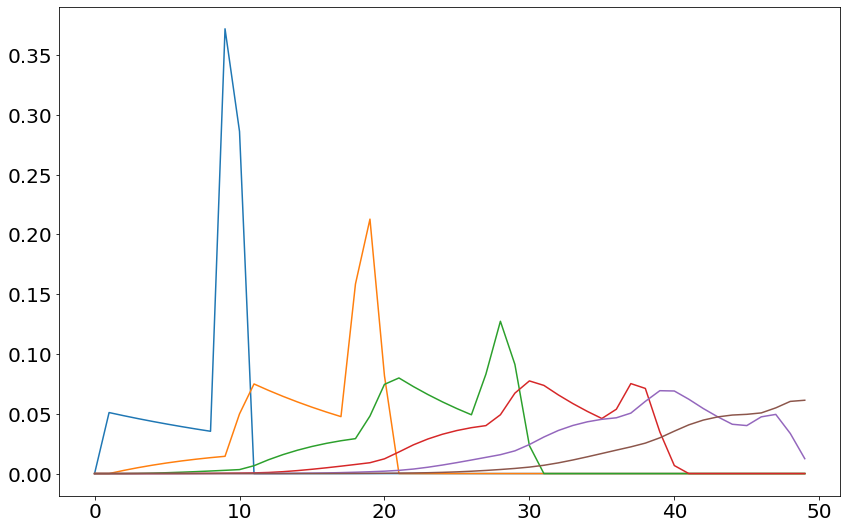

In [7]:
x = np.arange(50)
plt.plot(x, e4s_mult(x, 1))
plt.plot(x, e4s_mult(x, 2))
plt.plot(x, e4s_mult(x, 3))
plt.plot(x, e4s_mult(x, 4))
plt.plot(x, e4s_mult(x, 5))
plt.plot(x, e4s_mult(x, 6))
# plt.plot(x, e4s_mult(x, 7))
# plt.plot(x, e4s_mult(19, x))

In [7]:
e4md = MarkovSolver(e4s_mkv)
w4md = MarkovSolver(w4s_mkv)
e5md = MarkovSolver(e5s_mkv)
w5md = MarkovSolver(w5s_mkv)

PATHOLOGICAL MARKOV CHAIN


In [35]:
import multi_distr

In [39]:
importlib.reload(multi_distr)

<module 'multi_distr' from '/Users/albertxu/GenshinWishStats/multi_distr.py'>

In [40]:
e4mt = multi_distr.DupeTargMulti(e4md, e4s_mult, 500)

1.1865220372029193


In [51]:
print(np.sum(np.arange(1500) * e4mt(np.arange(1500), 1, True)))
print(np.sum(np.arange(1500) * e4mt(np.arange(1500), 2, True)))
print(np.sum(np.arange(1500) * e4mt(np.arange(1500), 3, True)))
print(np.sum(np.arange(1500) * e4mt(np.arange(1500), 4, True)))
print(np.sum(np.arange(1500) * e4mt(np.arange(1500), 6, True)))

34.43677933165677
68.88107796965193
103.32277754744328
137.7650938216118
206.65242546030268


In [52]:
np.sum(e4mt(np.arange(1500), 1, True))

0.9999999999999981

In [13]:
@np.vectorize
@cache
def e4hit(w):
    return np.sum(e4md(range(w+1)) * e4s_mult(w, range(w+1)), dtype=np.float)
@np.vectorize
@cache
def e5hit(w):
    return np.sum(e5md(range(w+1)) * e5s_mult(w, range(w+1)), dtype=np.float)
@np.vectorize
@cache
def w4hit(w):
    return np.sum(w4md(range(w+1)) * w4s_mult(w, range(w+1)), dtype=np.float)
@np.vectorize
@cache
def w5hit(w):
    return np.sum(w5md(range(w+1)) * w5s_mult(w, range(w+1)), dtype=np.float)

# w5hit_multi = MultiDistr(w5hit, 1000)

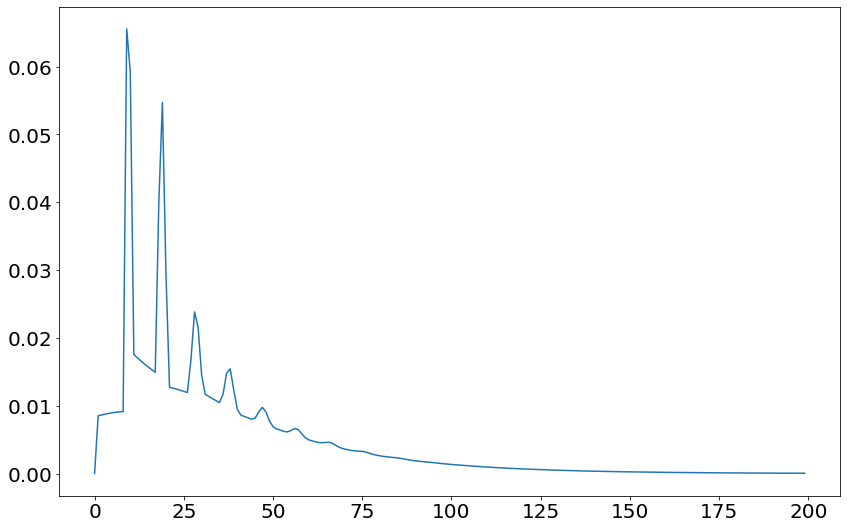

In [14]:
plt.plot(e4hit(np.arange(200)))

In [16]:
# set up 2F1 approximation
l2 = e4md.longterm_rate()
mu = e4s_mult.mean
s = e4s_mult.std
m2 = np.sqrt(mu*mu/s/s + 2*l2)/s - mu/s/s
xr = np.arange(2000, 2500)
c = np.mean(e4hit(xr) / np.exp(-m2*xr) / m2)
print(c, np.std(e4hit(xr) / np.exp(-m2*xr) / m2))

1.1865220372028418 8.037180454268472e-15


In [18]:
dt = 1 - c*m2 / (1-np.exp(-m2))

def exp_approx(x, n):
    k = (c*m2)**n
    poly = scipy.special.binom(x+n-2, n-1)
    if len(poly.shape) == 0:
        if n <= 1: poly = 1
    else:
        poly[n<=1] = 1
    return k * poly * np.exp(-m2*x)

def expconv_approxb(x, n):
    zarg = -c * m2 / dt
    hyp = scipy.special.hyp2f1(1-n, 1+x, 2, zarg)
    return c * m2 * np.exp(-m2*x) * n*dt**(n-1) * hyp

x = np.arange(1500)
pt = (x == 0).astype(int) * dt
delts = e4hit(x) - exp_approx(x, 1) - pt

In [20]:
len(delts) - np.where(np.cumsum(np.abs(delts[::-1])) > 1e-3)[0][0]

76

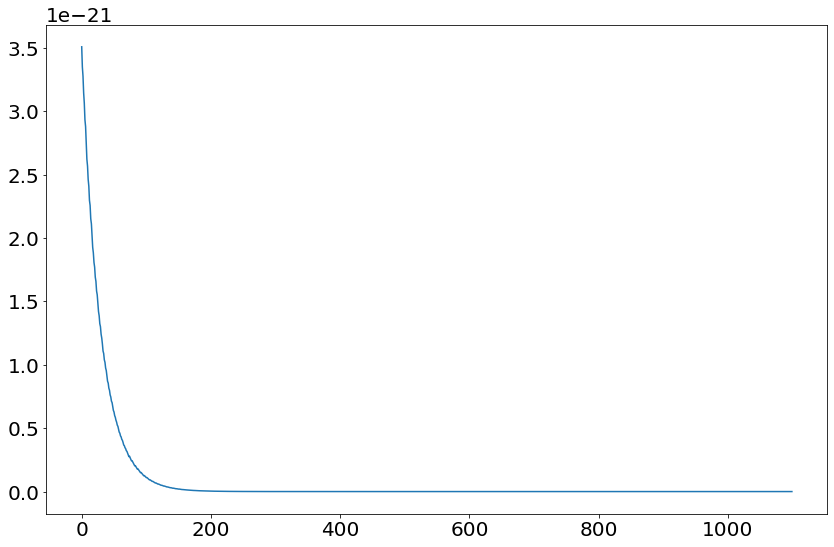

In [21]:
plt.plot(delts[400:])

In [22]:
derr_size = 500
d0 = np.array(delts[:derr_size])
multid = MultiDistr(lambda i: d0[i] if 0<=i<derr_size else 0, derr_size)

@np.vectorize
def exp_plus_delta(w, n):
    if w == 0:
        return expconv_approxb(w, n) + dt**n
    return expconv_approxb(w, n)

@np.vectorize
@cache
def convde(w, dn, en):
    if dn == 0:
        return exp_plus_delta(w, en)
    if en == 0:
        return multid(w, dn)
    iterlim = min(w+1, derr_size*dn)
    z = np.arange(iterlim)
    return np.sum(multid(z, dn) * exp_plus_delta(w - z, en), dtype=np.float)

@np.vectorize
@cache
def pmx_exact(x, nn):    
    return np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in range(nn+1)], axis=0)

@np.vectorize
@cache
def pmx_approx(x, nn):
    return np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in [0,1]], axis=0)

/Users/albertxu/GenshinWishStats/multi_distr.py:20: RuntimeWarning: invalid value encountered in sqrt
  self.std = np.sqrt(en2 - self.mean * self.mean)


In [26]:
x = np.arange(500)
dst = pmx_exact(x, 1)#/ np.sum(pmx_exact(x, 5))

np.sum(x * dst)

34.43675232523425

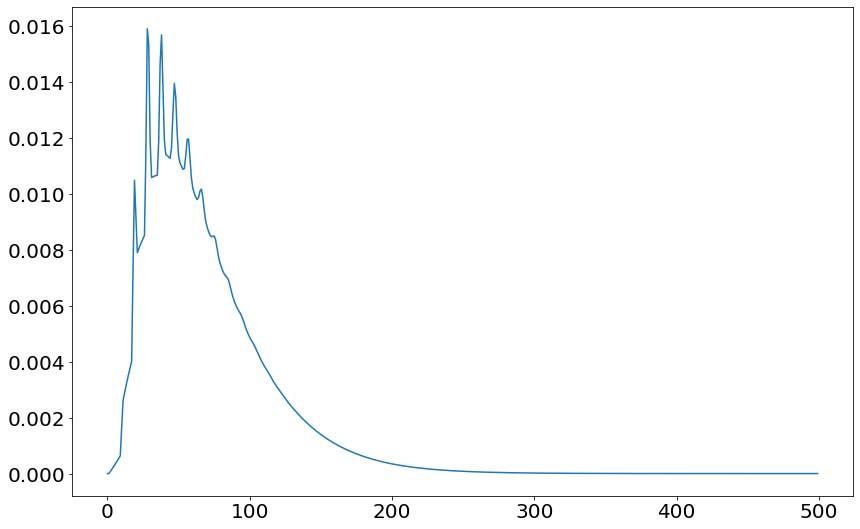

In [27]:
plt.plot(pmx_exact(x, 2))

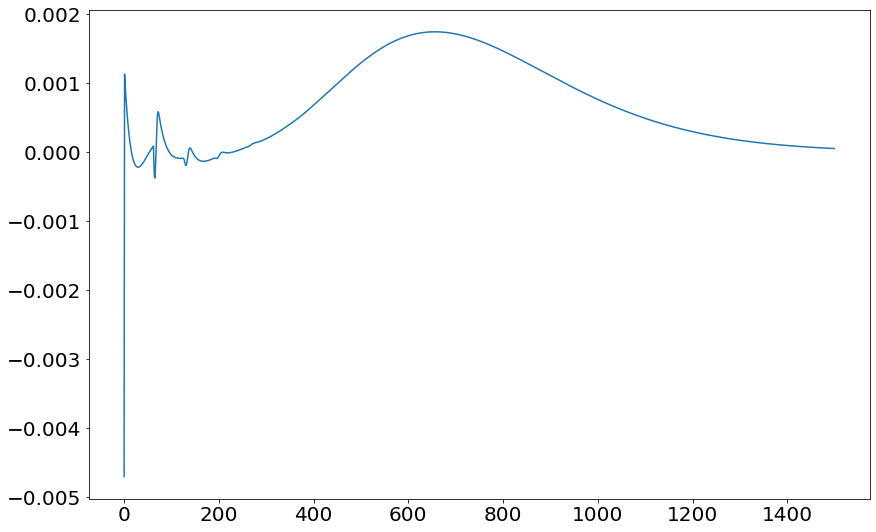

In [87]:
x = np.arange(0, 1500)
plt.plot(pmx_approx(x, 6))
# plt.plot(convde(x, 0, 3))

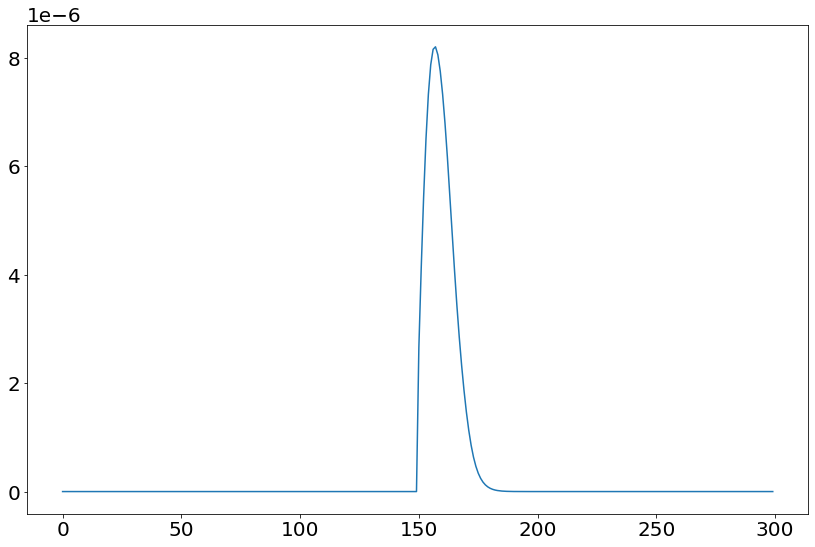

In [49]:
plt.plot(pmx_approx(np.arange(0, 300), 1) - w4hit_multi(np.arange(300), 1))

In [14]:
w4hit_multi = MultiDistr(w4hit, 80)

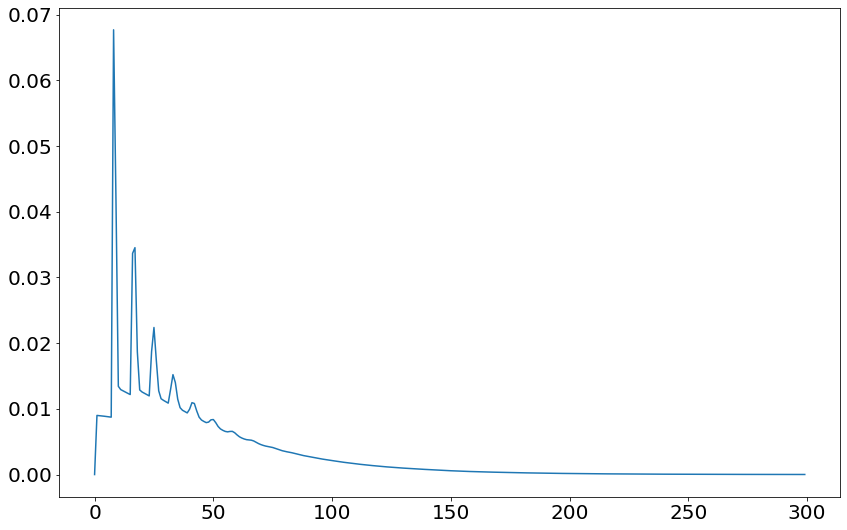

In [38]:
plt.plot(w4hit_multi(np.arange(300), 1))

In [133]:
e5hit_multi = MultiDistr(e5hit, 200)

In [153]:
x = np.arange(1200)
mean = np.sum(x * e5hit_multi(x, 7))
mean
# var = np.sum(x*x * e5hit_multi(x, 2)) - mean*mean

654.5539353891972

In [155]:
ds = np.cumsum(e5hit_multi(x, 7))
ds[655]

0.5044661162845425

In [157]:
np.argmin(np.abs(ds - .8))

751

In [152]:
mean

654.5539353891972

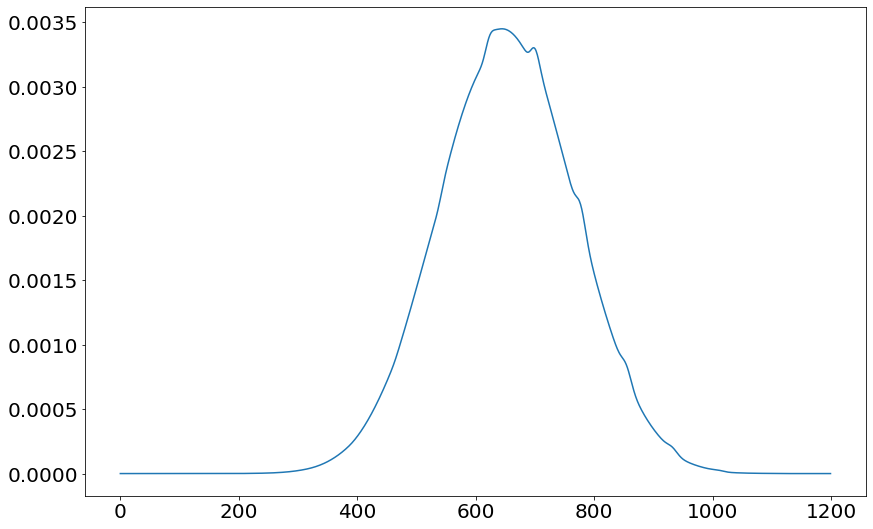

In [150]:
plt.plot(e5hit_multi(np.arange(1200), 7))

In [71]:
e4hit_multi = MultiDistr(e4hit, 500)

# l = -np.log((1+np.sqrt(13))/6)
# mu = e4s_mult.mean
# s = e4s_mult.std
# m2 = np.sqrt(mu*mu/s/s + 2*l)/s - mu/s/s
# c = np.mean(e4hit(np.arange(400, 500)) / np.exp(-m2*np.arange(400, 500)) / m2)
c = 1.1865220372029213

In [72]:
def exp_approx(x, n):
    k = (c*m2)**n
    poly = scipy.special.binom(x+n-2, n-1)
    if len(poly.shape) == 0:
        if n <= 1: poly = 1
    else:
        poly[n<=1] = 1
    return k * poly * np.exp(-m2*x)

def expconv_approxb(x, n):
    zarg = -c * m2 / dt
    hyp = scipy.special.hyp2f1(1-n, 1+x, 2, zarg)
    return c * m2 * np.exp(-m2*x) * n*dt**(n-1) * hyp

In [73]:
x = np.arange(400)

dt = 1 - c*m2 * (np.exp(m2)) / (np.exp(m2)-1)
pt = (x == 0).astype(int) * dt
delts = e4hit(x) - exp_approx(x, 1) - pt

# def mult_setp(n):
#     if n == 0:
#         return pt[0] + exp_approx(0, 1)
#     return exp_approx(n, 1)
# wow = MultiDistr(mult_setp, 1000)

In [74]:
d0 = np.array(delts[:80])
multid = MultiDistr(lambda i: d0[i] if 0<=i<80 else 0, 80)

@np.vectorize
def exp_plus_delta(w, n):
    if w == 0:
        return expconv_approxb(w, n) + dt**n
    return expconv_approxb(w, n)

@np.vectorize
@cache
def convde(w, dn, en):
    if dn == 0:
        return exp_plus_delta(w, en)
    if en == 0:
        return multid(w, dn)
    iterlim = min(w+1, 80*dn)
    z = np.arange(iterlim)
    return np.sum(multid(z, dn) * exp_plus_delta(w - z, en), dtype=np.float)
#     return np.sum([delt2[z] * exp_approx(w - z, n) for z in range(w+1)], dtype=np.float)

/Users/albertxu/GenshinWishStats/multi_distr.py:18: RuntimeWarning: invalid value encountered in sqrt
  self.std = np.sqrt(en2 - self.mean * self.mean)


In [93]:
np.sum(1-np.cumsum(np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in [0,1]], axis=0)))

240.7327261209865

In [101]:
np.sum(np.sum([scipy.special.binom(nn, i)*convde(np.arange(1000), i, nn-i) for i in [0,1]], axis=0))

1.0006691002364767

In [98]:
np.sum(1-np.cumsum(np.sum([scipy.special.binom(nn, i)*convde(np.arange(1000), i, nn-i) for i in [0,1]], axis=0)))

240.59958183576757

In [107]:
mmm = np.sum(np.arange(1000) * np.sum([scipy.special.binom(nn, i)*convde(np.arange(1000), i, nn-i) for i in [0,1]], axis=0))
mm = mmm / np.sum(np.sum([scipy.special.binom(nn, i)*convde(np.arange(1000), i, nn-i) for i in [0,1]], axis=0))

In [108]:
mm

241.10735708260307

In [118]:
dst = np.cumsum(e4hit_multi(x, nn))

In [119]:
dst[241]

0.55207783680862

In [120]:
np.argmin(np.abs(dst-.8))

302

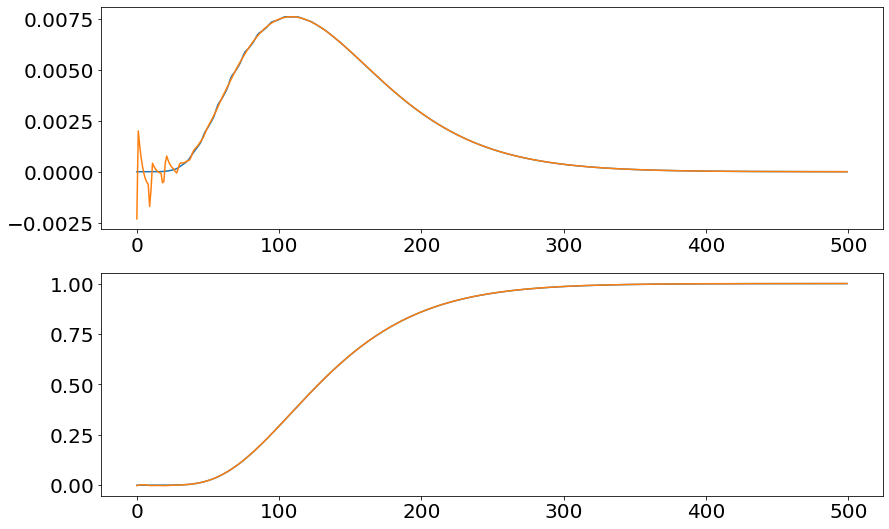

In [125]:
x = np.arange(500)

nn = 4
plt.subplot(211)
plt.plot(e4hit_multi(x, nn))
plt.plot(np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in [0,1]], axis=0))

plt.subplot(212)
plt.plot(np.cumsum(e4hit_multi(x, nn)))
plt.plot(np.cumsum(np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in [0,1]], axis=0)))

# plt.savefig('e4sc6_distr.png')

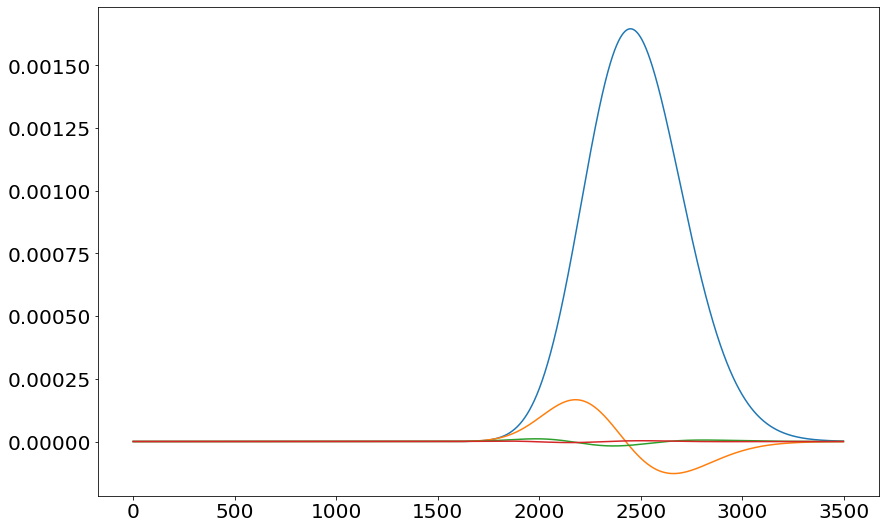

In [75]:
x = np.arange(3500)
plt.plot(convde(x, 0, 71))
plt.plot(71*convde(x, 1, 70))
plt.plot(71*35*convde(x, 2, 69))
plt.plot(71*70*69*convde(x, 3, 68)/2)

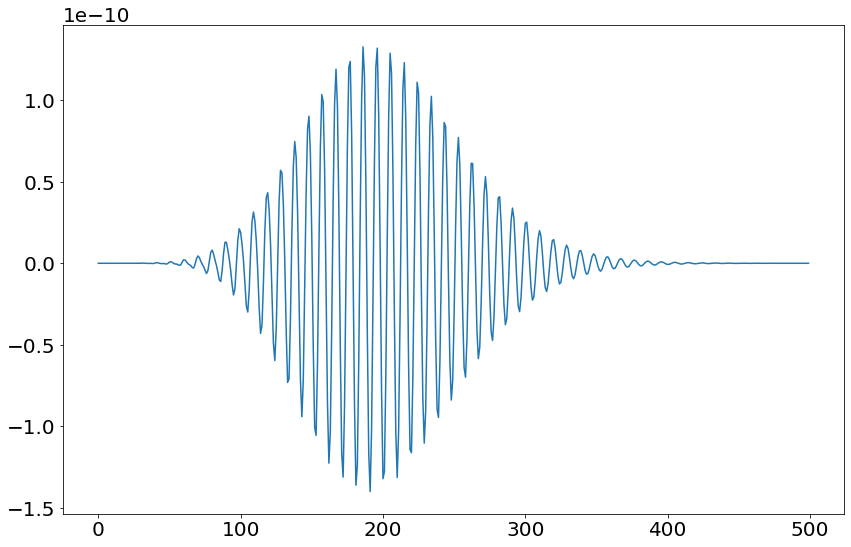

In [44]:
plt.plot(multid(np.arange(500), 20))

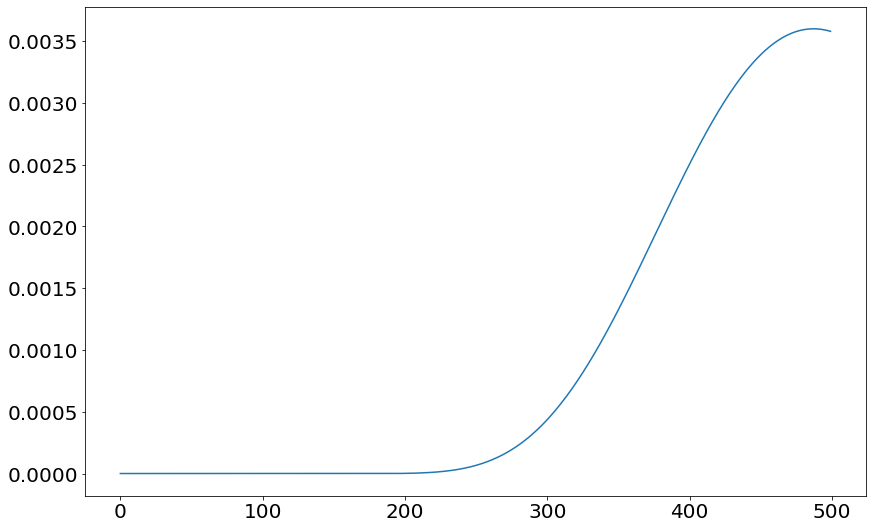

In [70]:
x = np.arange(500)

nn = 15

# plt.plot(np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in range(1)], axis=0))
plt.plot(np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in range(2)], axis=0))

In [662]:
c = 1.1865220372029237

l = -np.log((1+np.sqrt(13))/6)
mu = e4s_mult.mean
s = e4s_mult.std
m2 = np.sqrt(mu*mu/s/s + 2*l)/s - mu/s/s

def exp_approx(x, n):
    k = (c*m2)**n
    poly = scipy.special.binom(x+n-2, n-1)
    if len(poly.shape) == 0:
        if n <= 1: poly = 1
    else:
        poly[n<=1] = 1
    return k * poly * np.exp(-m2*x)

def exp_approxb(x, n):
    k = (c*m2)**n
    poly = scipy.special.binom(x-1, n)
    if len(poly.shape) == 0:
        if x <= 0: poly = 0
    else:
        poly[x<=0] = 0
    return k * poly * np.exp(-m2*x)

In [531]:
np.int64(5).shape

()

In [558]:
dt

nan

In [873]:
delts

array([-4.02902318e-02, -3.04450808e-02, -2.90003399e-02, ...,
       -2.52778305e-33, -2.51574599e-33, -2.47963480e-33])

In [594]:
exp_approx(0, 1)

0.0

In [576]:
scipy.special.binom(-1.1, 0)

1.0

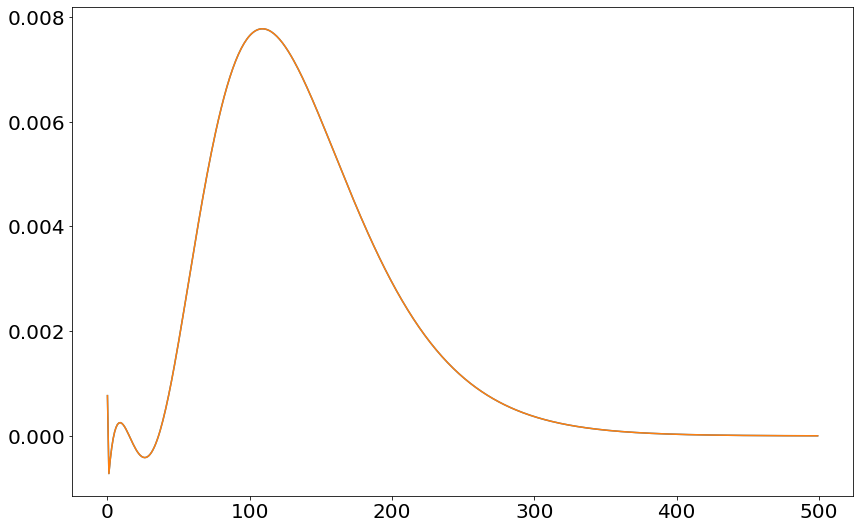

In [911]:
plt.plot(wow(np.arange(500), 4))
plt.plot(convde(np.arange(500), 0, 4))

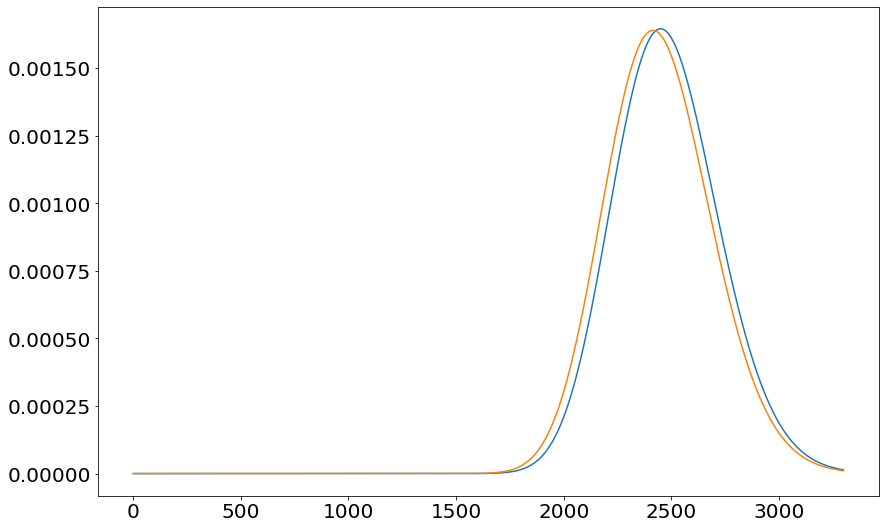

In [972]:
x = np.arange(3300)

nn = 71
# plt.plot(e4hit_multi(x, nn))
plt.plot(np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in range(1)], axis=0))
plt.plot(np.sum([scipy.special.binom(nn, i)*convde(x, i, nn-i) for i in range(2)], axis=0))

# plt.plot(convde(x, 0, 1) + convde(x, 1, 0) + pt300)
# plt.plot(convde(x, 0, 4) + 4*convde(x, 1, 3) + 6*convde(x, 2, 2) + 4*convde(x, 3, 1) + convde(x, 4, 0))
# plt.plot(convde(x, 0, 5) + 5*convde(x, 1, 4) + 10*convde(x, 2, 3) + 10*convde(x, 3, 2) + 5*convde(x, 4, 1) + convde(x, 5, 0))

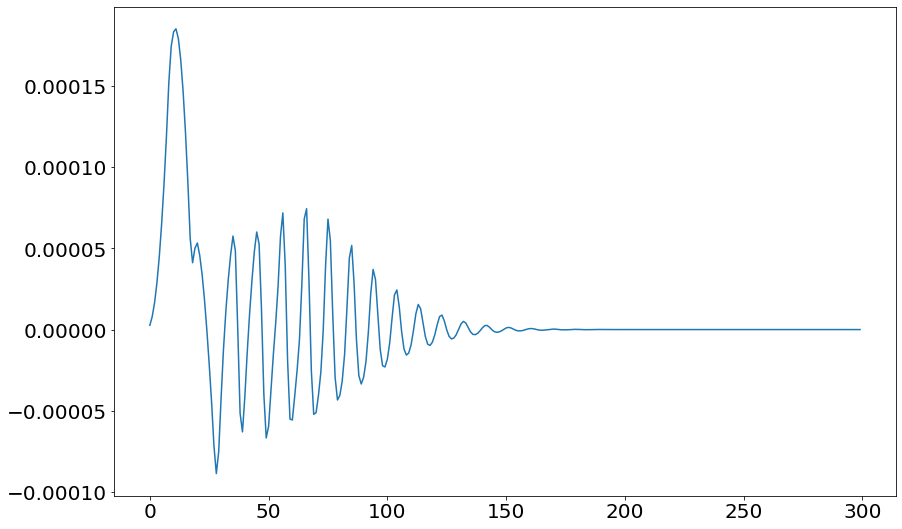

In [732]:
x = np.arange(300)
# plt.plot(multid(x, 1))
plt.plot(multid(x, 4))

In [669]:
x = np.arange(1200)
delts = e4hit_multi(x, 1) - exp_approx(x, 1)
# dt = np.sum(delts)
dt = 1 - c*m2 * (np.exp(m2)) / (np.exp(m2)-1)

d2 = delts.copy()
d2[0] -= dt

pt = (x == 0).astype(int) * dt

def expconv_approx(x, n):
    zarg = -c * m2 / dt
    hyp = scipy.special.hyp2f1(1-n, x, 2, zarg)
    return c * m2 * np.exp(-m2*x) * n*dt**(n-1) * hyp

def expconv_approxb(x, n):
    zarg = -c * m2 / dt
    hyp = scipy.special.hyp2f1(1-n, 1+x, 2, zarg)
    return c * m2 * np.exp(-m2*x) * n*dt**(n-1) * hyp

def expconv_approxc(x, n):
    zarg = c * m2 / dt
    hyp = scipy.special.hyp2f1(1-n, 1-x, 2, zarg)
    return c * m2 * np.exp(-m2*x) * n*dt**(n-1) * hyp

In [596]:
@np.vectorize
@cache
def convdelt(w, n):
    if n == 0: return 0
    if n == 1: return delt2[w]
    return np.sum([delt2[z] * convdelt(w - z, n-1) for z in range(w+1)], dtype=np.float)

In [644]:
@np.vectorize
@cache
def convde(w, n):
    return np.sum([delt2[z] * exp_approx(w - z, n) for z in range(w+1)], dtype=np.float)

# @np.vectorize
# @cache
# def convd5(w, n):
#     return np.sum([convdelt(z,5) * exp_approx(w - z, n) for z in range(w+1)], dtype=np.float)

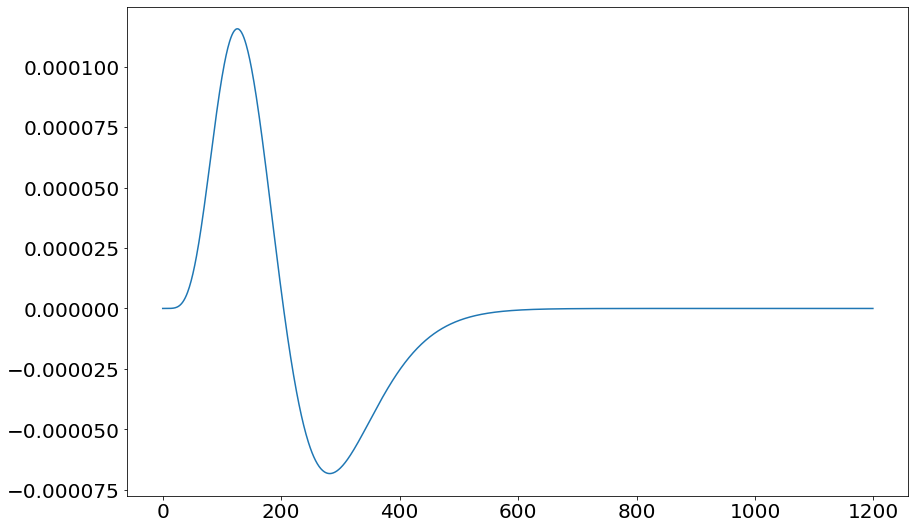

In [633]:
# plt.plot(delt2)
plt.plot(convde(x))

In [583]:
x = np.arange(0, 400)

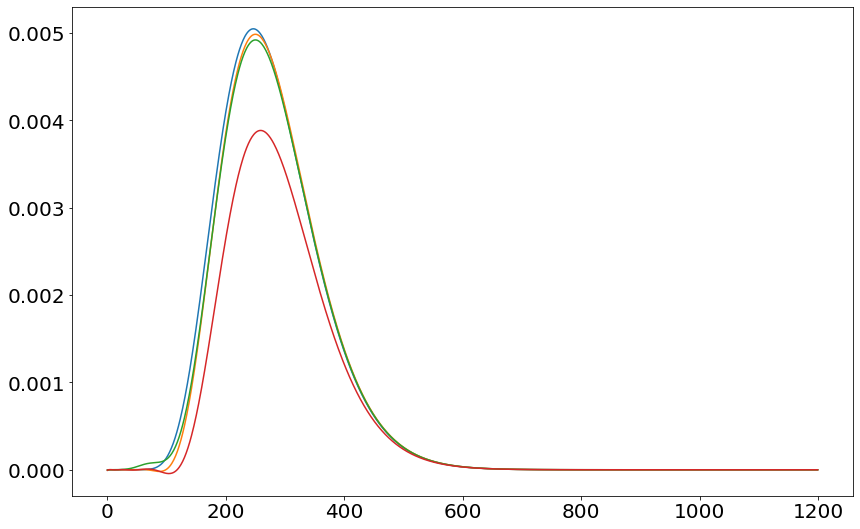

In [648]:
# esto = dt**3 * convdelt(x, 1) + dt**2 * convdelt(x, 2) + dt*convdelt(x, 3) + convdelt(x, 4) + 4*dt**3 * exp_approx(x, 1) + 6*dt**2 * exp_approx(x, 2) + 4*dt*exp_approx(x, 3) + exp_approx(x, 4)
# esto = dt*pt + convdelt(x, 2) + exp_approx(x, 2) + 2*dt*convdelt(x, 1) + 2*dt*exp_approx(x, 1) #+ 2*convde(x)


plt.plot(e4hit_multi(x, 8))
plt.plot(expconv_approx(x, 8))
plt.plot(expconv_approx(x, 8) + convde(x, 7))
# plt.plot(exp_approx(x, 3))
plt.plot(expconv_approxb(x, 8))
# plt.plot(expconv_approxc(x, 8) + convde(x))

# plt.plot(esto)

# plt.plot(e4hit_multi(x, 2) - esto)

In [368]:
np.sum(np.arange(1200)*delts) / np.sum(delts)

2.4286188300567466

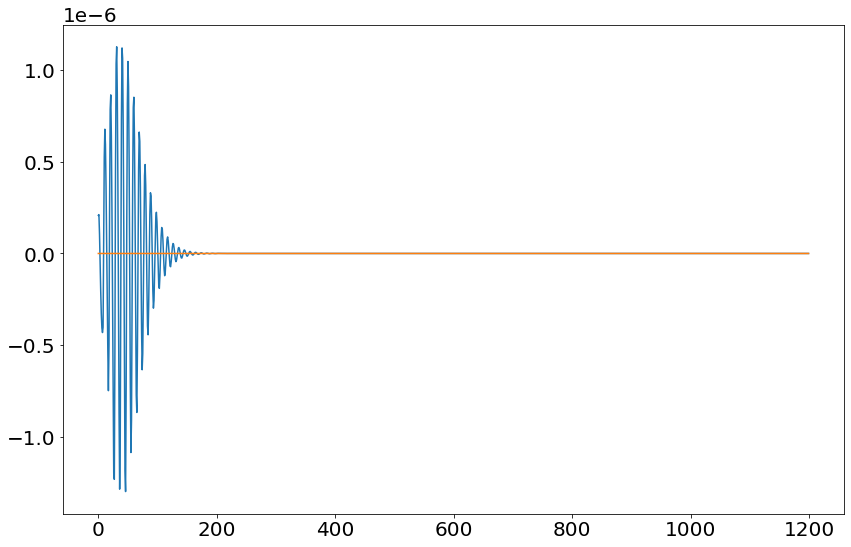

In [415]:
plt.plot(convd5(x, 2))
plt.plot(np.sum(delt2)**5 * exp_approx(x, 2))

In [343]:
np.sum(delts)**4

0.0018282849137140366

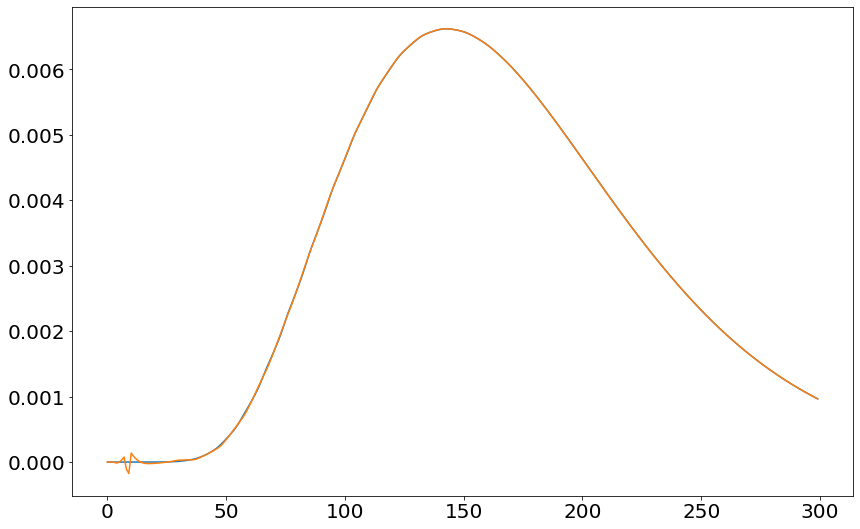

In [380]:
x = np.arange(300)
plt.plot(e4hit_multi(x, 5))

dt = np.sum(delts)
dm = np.sum(np.arange(1200)*delts) / dt

plt.plot(convdelt(x, 5) + 5*(dt**4 * exp_approx(x-4*dm, 1)) + 10*(dt**3 * exp_approx(x-dm*3, 2)) + 10*dt**2*exp_approx(x-dm*2, 3) + 5*np.sum(delts)*exp_approx(x-dm,4)+exp_approx(x,5))
# plt.plot(np.sum(delts) * exp_approx(np.arange(200), 1))

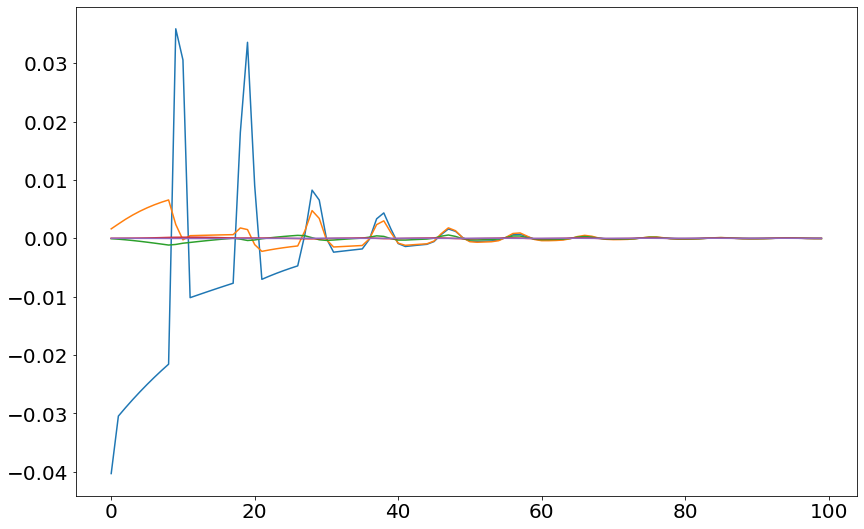

In [279]:
x = np.arange(0, 100)
plt.plot(convdelt(x, 1))
plt.plot(convdelt(x, 2))
plt.plot(convdelt(x, 3))
plt.plot(convdelt(x, 4))
plt.plot(convdelt(x, 5))

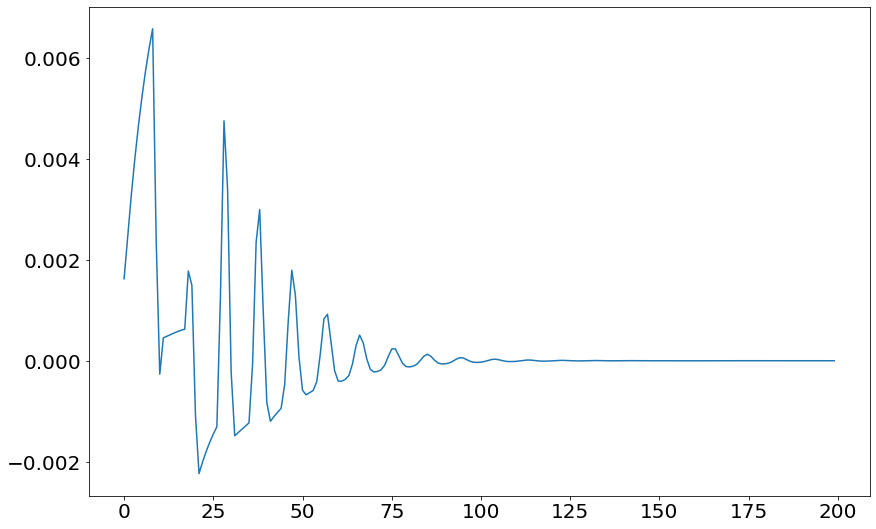

In [267]:
plt.plot(convdelt(np.arange(200), 2))

In [180]:
c

1.1865220372029237

In [245]:
np.sum(e4hit_multi(np.arange(1200), 5))

0.9999999999994308

In [189]:
np.sum(x * e4hit_multi(x, 6))

205.84171827353458

In [217]:
delts = e4hit_multi(x, 1) - c*m2 * np.exp(-m2*x)

-0.5021926207411775

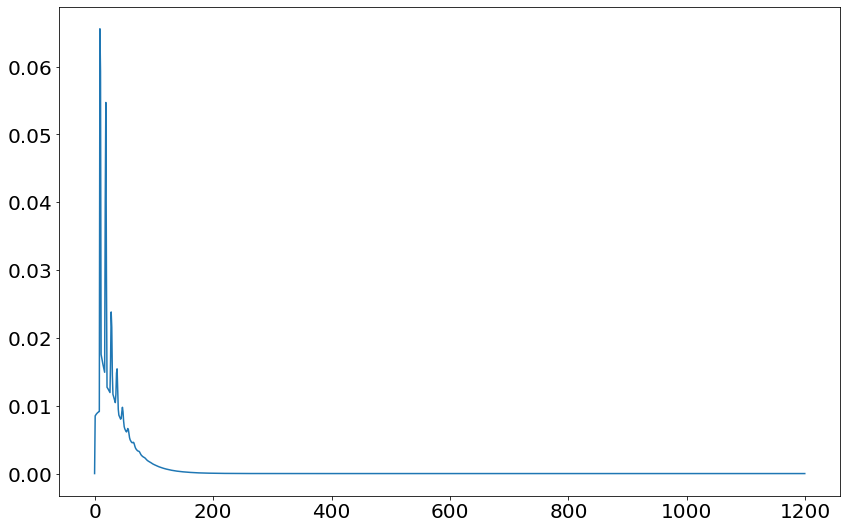

In [221]:
plt.plot(delts + c*m2 * np.exp(-m2*x))

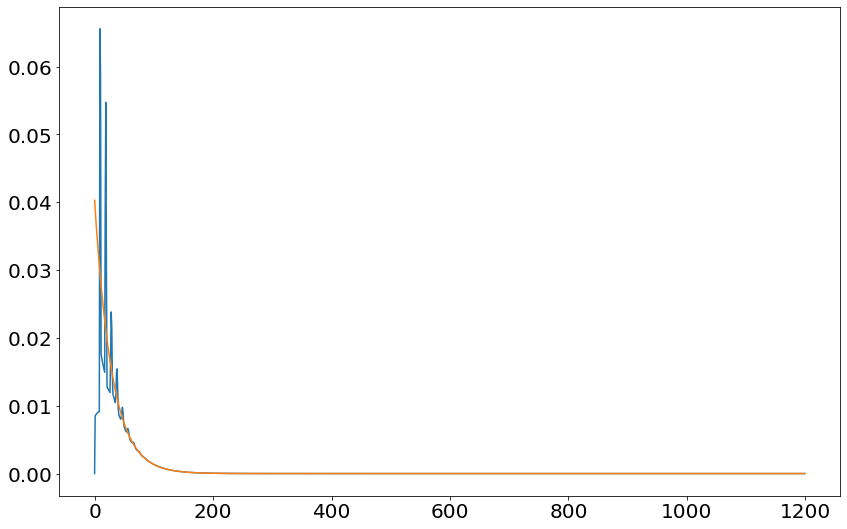

In [216]:
x = np.arange(0,1200)

nn = 1

bb = (c*m2)**nn * scipy.special.binom(x+nn-1, nn-1) * np.exp(-m2 * x)
plt.plot(e4hit_multi(x, nn))
plt.plot(bb)
# plt.plot((e4hit_multi(x, nn) - bb) / bb)

In [114]:
c*(1 - np.exp(l))

-0.3592499664971806

In [113]:
np.exp(-1.1415066649383128)

0.31933752452815356

In [55]:
m

-0.03395658107840906

In [63]:
mu, s, l

(7.652617629257079, 2.8370502879045536, 0.26449709431570845)

In [7]:
l = -np.log((1+np.sqrt(13))/6)
mu = e4s_mult.mean
s = e4s_mult.std
mu/s/s - np.sqrt(mu*mu/s/s + 2*l)/s

In [29]:
m2 = mu/s/s - np.sqrt(mu*mu/s/s + 2*l)/s

In [115]:
m2

-0.0339565810784358

In [27]:
x = np.arange(1, 500)

In [38]:
b = np.mean((np.log([e4hit(z) for z in x]) - m2*x)[300:])

In [78]:
c = (1 - np.sum([e4hit(z) for z in range(270)])) / np.exp(m2*269)

In [84]:
(1 - np.sum([e4hit(z) for z in range(230)])) / np.exp(m2*229)

1.1664909257826572

In [81]:
c

1.1664909290290375

In [112]:
c = -e4hit(400) / (m2*np.exp(m2*400))
c

1.1865220372029237

In [118]:
c - 1.1865220372029236661338147750939

0.0

In [86]:
e4hit(400)

5.0855444064553476e-08

In [126]:
x = np.arange(500)
delt = c*m2*np.exp(m2*x) + [e4hit(z) for z in x]

In [135]:
np.sum(c*m2*np.exp(m2*x))

-1.2067811097111434

In [130]:
np.sum(delt)

-0.206781160767597

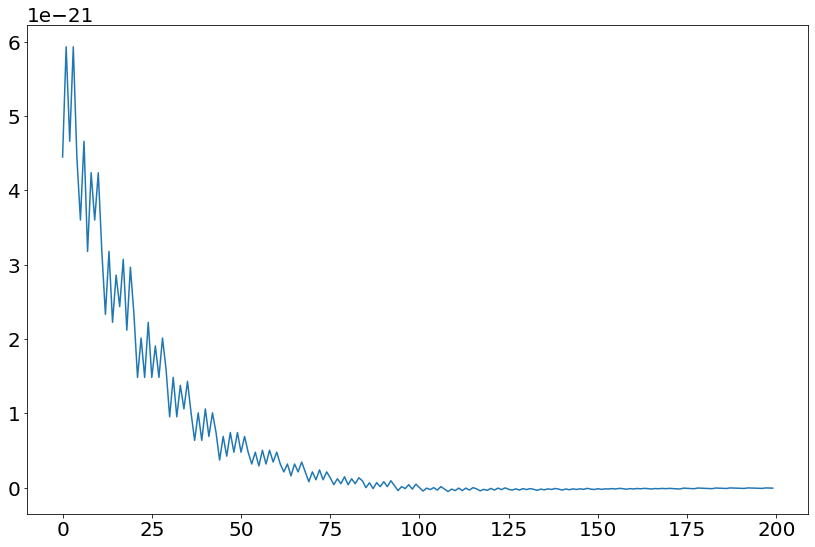

In [110]:
x = np.arange(300, 500)
plt.plot(c*m2*np.exp(m2*x) + [e4hit(z) for z in x])
# plt.plot(-c*m2*np.exp(m2*x))

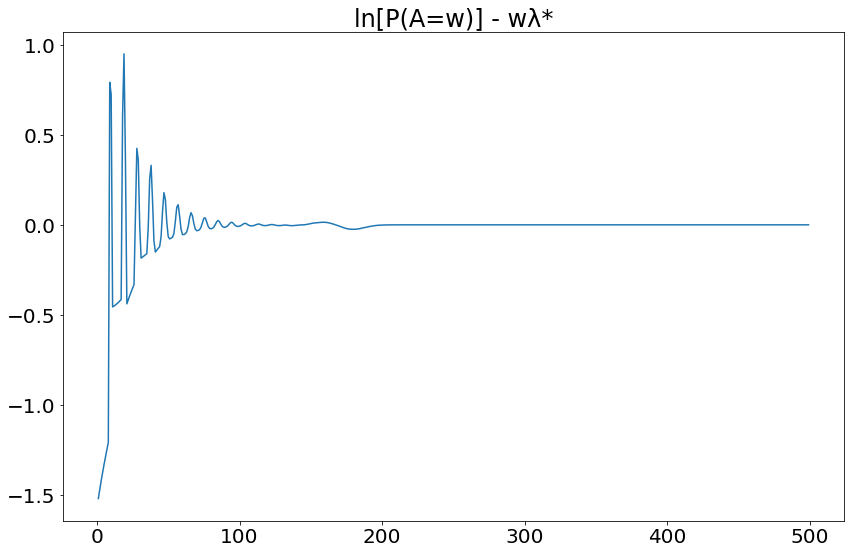

In [39]:
plt.plot(x, np.log([e4hit(z) for z in x]) - m2*x - b)
plt.title('ln[P(A=w)] - wλ*')
plt.savefig('4s_dupe_expfit.png')

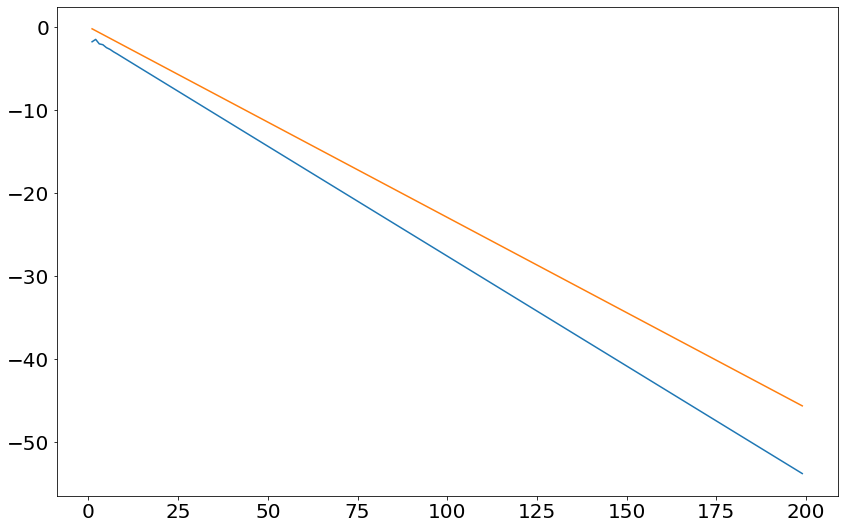

In [17]:
x = np.arange(1, 200)

l = -np.log((1+np.sqrt(13))/6)
c = -.5 - 2/np.sqrt(13)

plt.plot(x, np.log(e4md(x)))
plt.plot(x, (mu/s/s - np.sqrt(mu*mu/s/s - 2*l)/s - l)*x)
# plt.plot(x, np.log(c*(1 - np.exp(l))) -l * x)
# plt.plot(e4md(x) - c*(1 - np.exp(l)) * np.exp(-l * x))

In [8]:
lin = np.log([e4hit(w) for w in x])

In [12]:
m = np.mean((lin[1:] - lin[0]) / np.arange(1, len(lin)))
b = np.mean(lin - x*m)

In [27]:
m

-0.03395658107840906

In [37]:
np.log((1+np.sqrt(13))/6) / e4s_mult.mean

-0.034562957033747156

In [31]:
m2 = np.log((1+np.sqrt(13))/6) / e4s_mult.mean

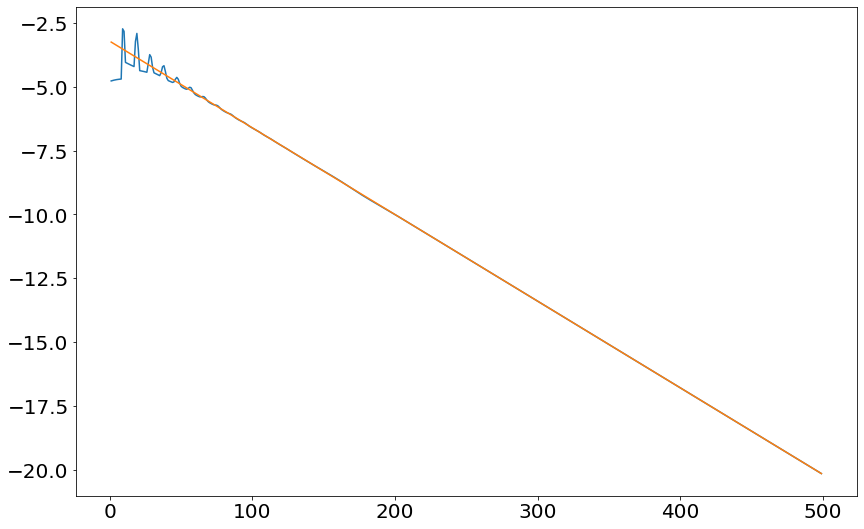

In [36]:
x = np.arange(1, 500)
plt.plot(x, np.log([e4hit(int(w)) for w in x]))
plt.plot(x, x*m + b)
# plt.plot(x, np.log([e4hit(int(w)) for w in x]) - (x*m+b))

In [647]:
line = np.log(e4md(range(40, 190)))
m = (line[-1] - line[0]) / (189 - 40)
b = line[-1] - 189*m

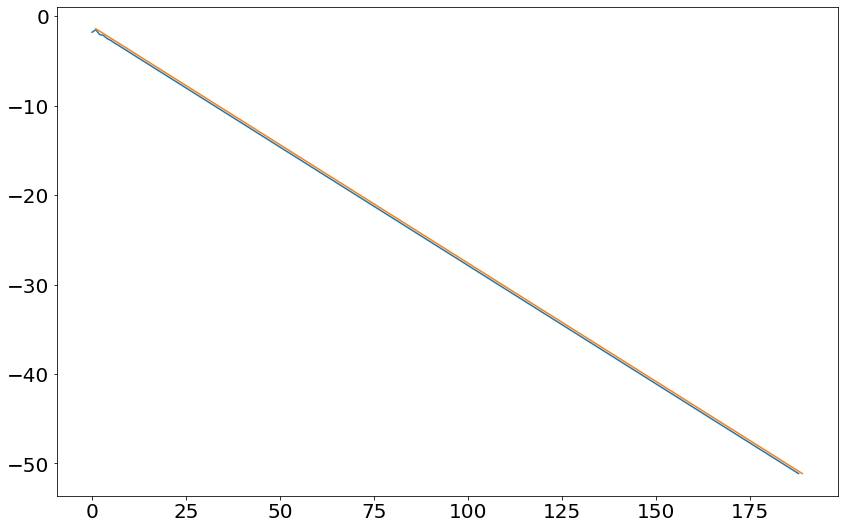

In [652]:
plt.plot(np.log(e4md(range(1, 190))))
plt.plot(np.arange(1, 190), b + m*np.arange(1, 190))

In [594]:
el, ev = np.linalg.eig([[3/5,4/5,0],[1/4,0,0],[3/20,1/5,1]])

In [599]:
el

array([ 1.        , -0.23851648,  0.83851648])

In [609]:
ev

array([[ 0.        ,  0.68991327, -0.60040054],
       [ 0.        , -0.72312956, -0.17900678],
       [ 1.        ,  0.03321629,  0.77940732]])

In [619]:
(np.linalg.pinv(ev) @ [1, 0, 0]) * ev[-1]

array([ 1.        ,  0.01066218, -1.01066218])

In [617]:
-.5 + 11/(4*np.sqrt(29)), -.5 - 11/(4*np.sqrt(29))

(0.010662179986892673, -1.0106621799868927)

In [346]:
# https://paimon.moe/wish/tally/300013
#  Eula char banner
paimonmoe = [122,107,109,118,100,103,103,103,107,116,104,87,96,87,95,86,86,107,95,90,99,64,88,87,74,71,79,87,77,74,77,76,93,76,71,91,67,87,79,81,86,59,78,53,89,74,88,88,71,73,76,73,81,73,88,69,67,76,78,62,74,63,81,78,86,54,63,64,70,71,66,68,56,732,1266,1662,1733,1655,1453,1074,773,415,207,104,44,14,3,1,1,1]
print(sum(paimonmoe))
pm = np.array(paimonmoe) / sum(paimonmoe)

17153


In [22]:
@cache
def e_5s(w):
    def e5_phw(w):
        if 1 <= w <= 73:
            return .006
        elif 73 <= w <= 90:
            return .006 + (1-.006)/17 * (w-73)
        else:
            return 0
    return np.prod([1-e5_phw(w2) for w2 in range(w)]) * e5_phw(w)

In [577]:
# https://paimon.moe/wish/tally/300013/
#  Eula char banner
pai = [6652, 6294, 5919, 5678, 5243, 4875, 4731, 4474, 46038, 35283]
print(sum(pai))
pm = np.array(pai) / sum(pai)

125187


In [578]:
def e4_phw(w):
    if 1 <= w <= 8:
        return .051
#     elif 8 <= w <= 10:
#         return .051 + (1 - .051)/2 * (w-8)
    elif w == 9:
        return 13/23
    elif w == 10:
        return 1
    return 0

@cache
def e_4s(w):
    return np.prod([1-e4_phw(w2) for w2 in range(w)]) * e4_phw(w)

In [348]:
# https://paimon.moe/wish/tally/400008
#  Homa weapon banner
paimonmoe = [144,124,134,131,126,132,143,144,123,130,140,125,117,115,112,110,123,120,114,112,92,106,113,82,83,93,93,110,93,93,79,84,95,88,78,81,94,68,75,73,95,79,68,90,72,75,73,73,61,83,64,64,70,87,85,94,87,80,71,63,61,90,622,1169,1370,1369,1270,896,545,308,179,62,28,4,4,2,2,1,1,1,0,1,1,2,0,0,1,0,0,0]
paaaaaaaa = [87,80,84,85,103,88,100,95,74,86,85,76,78,69,69,79,66,82,59,65,63,50,60,67,64,54,68,65,53,66,65,58,58,54,58,47,61,52,52,68,56,56,58,55,53,59,53,49,50,47,53,58,51,76,57,63,59,63,64,53,63,71,456,807,989,1026,911,679,487,277,132,51,22,6,3,3,1,1,1,2,2,2,0,0,0,0,0,2,1,0]
pm = np.array(paimonmoe) + np.array(paaaaaaaa)
print(np.sum(pm))
pm = pm / np.sum(pm)

23736


In [268]:
pts = [[0, .009], [1, .07978], [7,.49], [10, .55], [13, .24], [16, .1], [28, 1]]
x, y = np.array(pts).T
cinterp = interp1d(x+62, y, kind='cubic')
def w5_phw(w):
#     w = w - 1
    if 1 <= w <= 62:
        return .009
    elif 62 <= w <= 90:
        return cinterp(w)
    else:
        return 0

@cache
def w_5s(w):
    return np.prod([1-w5_phw(w2) for w2 in range(w)]) * w5_phw(w)

In [446]:
pai = [5299, 5000, 4528, 4334, 4097, 3937, 3420, 34043, 16912, 180]
print(sum(pai))
pm = np.array(pai) / sum(pai)

81750


In [471]:
def w4_phw(w):
    if 1 <= w <= 7:
        return .06
    if w == 8:
        return 2/3
    elif w == 9:
        return .9895
    elif w == 10:
        return 1
    return 0

@cache
def w_4s(w):
    return np.prod([1-w4_phw(w2) for w2 in range(w)]) * w4_phw(w)

In [579]:
stdevs = np.sqrt(pm * (1-pm) / sum(pai))
margins = np.array([pm[n] / (1-sum(pm[:n])) for n in range(1, 10)])

In [580]:
e_5s_multi = distr.MultiDistr(e_5s, 90)
e_4s_multi = distr.MultiDistr(e_4s, 10)
w_5s_multi = distr.MultiDistr(w_5s, 90)
w_4s_multi = distr.MultiDistr(w_4s, 10)

In [498]:
def e4_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 2 / (np.sqrt(13))
    a3= -.5 + 2 / (np.sqrt(13))
    l2 = (1+np.sqrt(13))/6
    l3 = (1-np.sqrt(13))/6
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def e_4s_hit(w):
    return sum([e4_pan(n) * e_4s_multi.p_iter(w, n) for n in range(w+1)])

In [551]:
def w_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 11/(4*np.sqrt(29))
    a3 = -.5 + 11/(4*np.sqrt(29))
    l2 = (3+np.sqrt(29)) / 10
    l3 = (3-np.sqrt(29)) / 10
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def w_4s_hit(w):
    return sum([w_pan(n) * w_4s_multi.p_iter(w, n) for n in range(w+1)])

In [560]:
def w5_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 7/(2*np.sqrt(41))
    a3 = -.5 + 7/(2*np.sqrt(41))
    l2 = (3+np.sqrt(41)) / 16
    l3 = (3-np.sqrt(41)) / 16
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def w_5s_hit(w):
    return sum([w5_pan(n) * w_5s_multi.p_iter(w, n) for n in range(w+1)])

In [561]:
np.sum(np.arange(500) * [w_5s_hit(w) for w in range(500)])

120.33554097431139

In [565]:
np.cumsum([w_5s_hit(w) for w in range(500)])[105]

0.5347301221509078

In [564]:
np.argmin(np.abs(np.cumsum([w_5s_hit(w) for w in range(500)]) - .5))

93

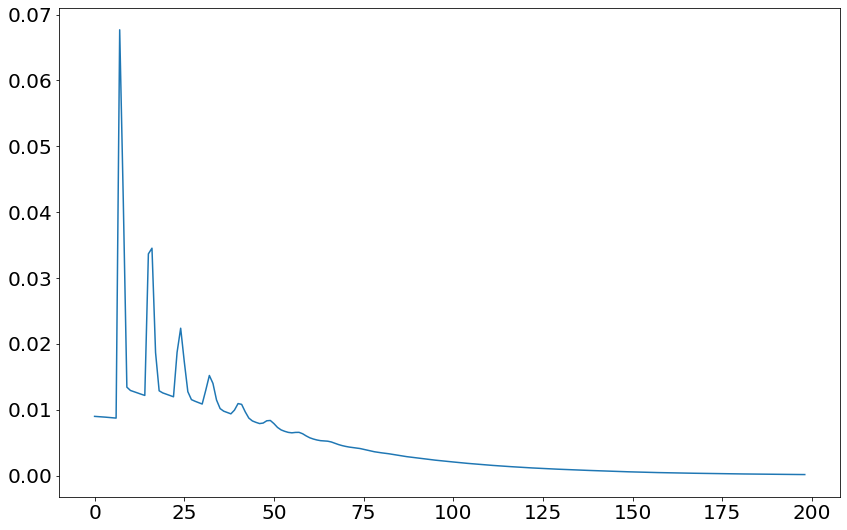

In [553]:
plt.plot([w_4s_hit(w) for w in range(1, 500)])

In [506]:
e_4s_hit(140) / e_4s_hit(139)

0.9676941978018309

In [530]:
e_4s_hit(309) / e_4s_hit(308)

0.9666134730409572

In [542]:
np.sum(np.arange(600) * [e_4s_hit(w) for w in range(600)])

34.43677825530884

In [546]:
cdf = np.cumsum([e_4s_hit(w) for w in range(600)])

In [549]:
cdf[25]

0.49551226876215676

In [550]:
np.argmin(np.abs(cdf - .8))

52

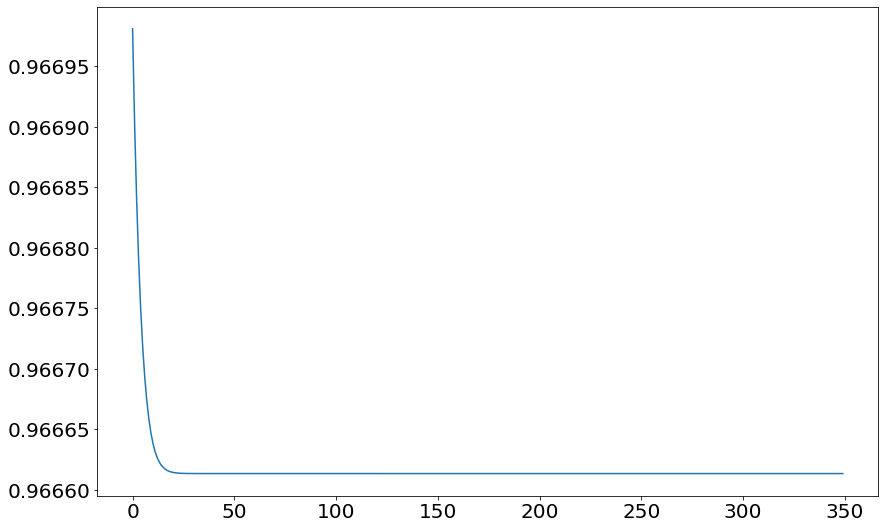

In [529]:
plt.plot([e_4s_hit(w) / e_4s_hit(w-1) for w in range(200, 550)])
# plt.plot([0, 300], [l2, l2])

In [589]:
np.sum(np.arange(500) * [w_4s_hit(w) for w in range(500)])

42.033647874599126

In [591]:
np.cumsum([w_4s_hit(w) for w in range(500)])[30]

0.5018378226185979

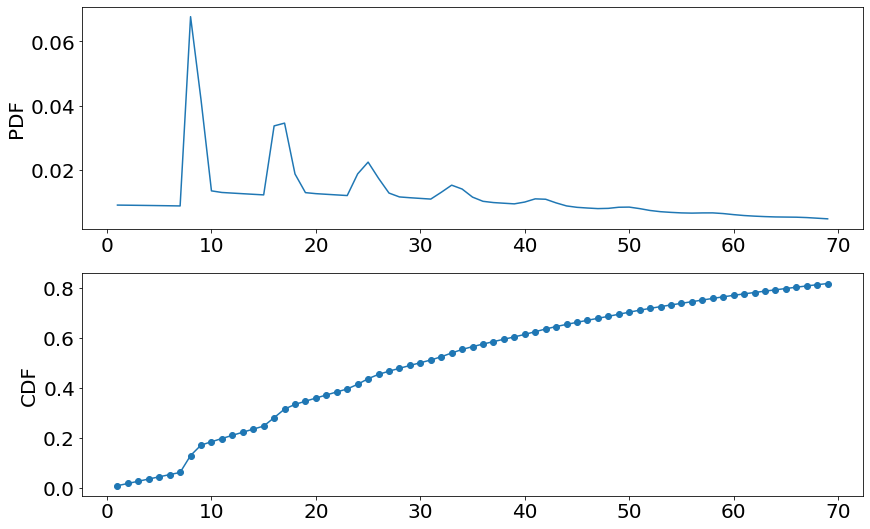

In [586]:
plt.subplot(211)
plt.plot(range(1, 70), [w_4s_hit(w) for w in range(1, 70)])
plt.ylabel('PDF')

plt.subplot(212)
plt.plot(range(1, 70), np.cumsum([w_4s_hit(w) for w in range(1, 70)]), marker='o')
plt.ylabel('CDF')

# plt.savefig('w4s_targ_dist.png')

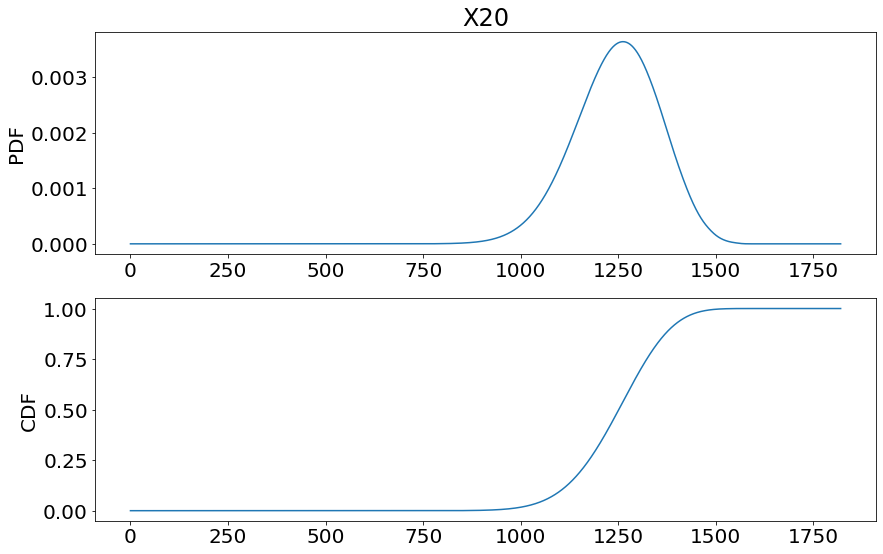

In [497]:
i = 20
plt.subplot(211)
plt.plot(e_5s_multi.get_distr(i))
plt.title(f'X{i}')
plt.ylabel('PDF')
plt.subplot(212)
plt.plot(np.cumsum(e_5s_multi.get_distr(i)))
plt.ylabel('CDF')

plt.savefig(f'pdfcdf{i}.png')

In [476]:
w_4s_multi.mean, w_4s_multi.std

(6.725613227292525, 2.5161877507433426)

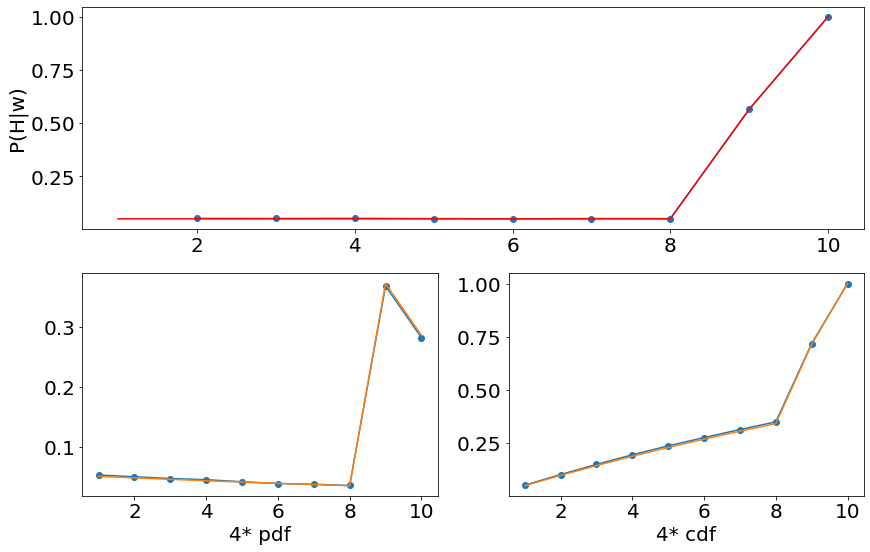

In [583]:
plt.subplot(211)
ml = np.array([(pm[n] - stdevs[n]) / (1-sum(pm[:n])) for n in range(1, 10)])
mr = np.array([(pm[n] + stdevs[n]) / (1-sum(pm[:n])) for n in range(1, 10)])
plt.plot(range(2, 11), margins, marker='o')
# plt.plot(ml, color='orange')
# plt.plot(mr, color='orange')

plt.plot(range(1, 11), [e4_phw(n) for n in range(1, 11)], color='red')
plt.ylabel('P(H|w)')

plt.subplot(223)
plt.plot(range(1, 11), pm, marker='o')
plt.plot(range(1, 11), e_4s_multi.get_distr(1)[1:-1])
plt.xlabel('4* pdf')

plt.subplot(224)
plt.plot(range(1, 11), np.cumsum(pm), marker='o')
plt.plot(range(1, 11), np.cumsum(e_4s_multi.get_distr(1)[1:-1]))
plt.xlabel('4* cdf')
plt.savefig('e4_margin.png')

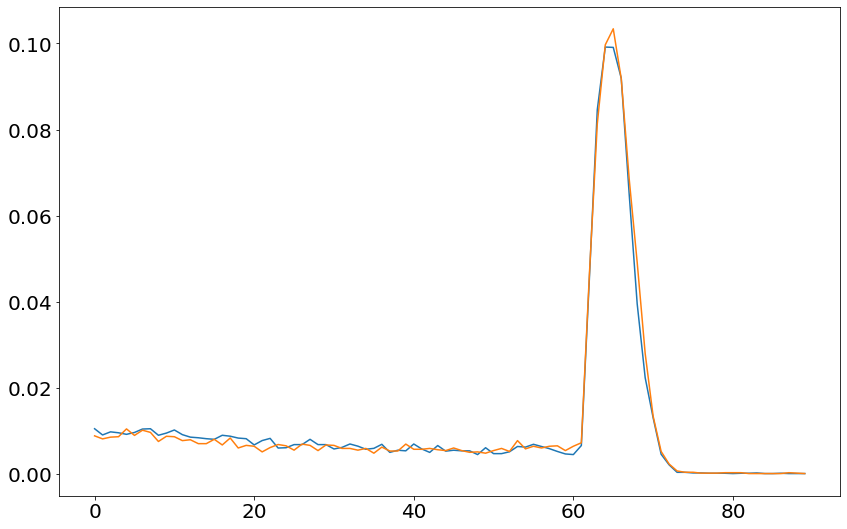

In [317]:
plt.plot(np.array(paimonmoe) / np.sum(paimonmoe))
plt.plot(np.array(paaaaaaaa) / np.sum(paaaaaaaa))


In [25]:
paimonmoe.index(622)

62

In [54]:
stdevs = np.sqrt(pm * (1-pm) / sum(paimonmoe))
margins = np.array([pm[n] / (1-sum(pm[:n])) for n in range(1, 90)])

In [64]:
paaaaaaaa[76] + paimonmoe[76]

3

-3.2121613249441665e-05

In [322]:
w_5s(90)

3.547752304461289e-08

In [324]:
sum([w_5s(w) for w in range(1,92)])

0.9999999999999993

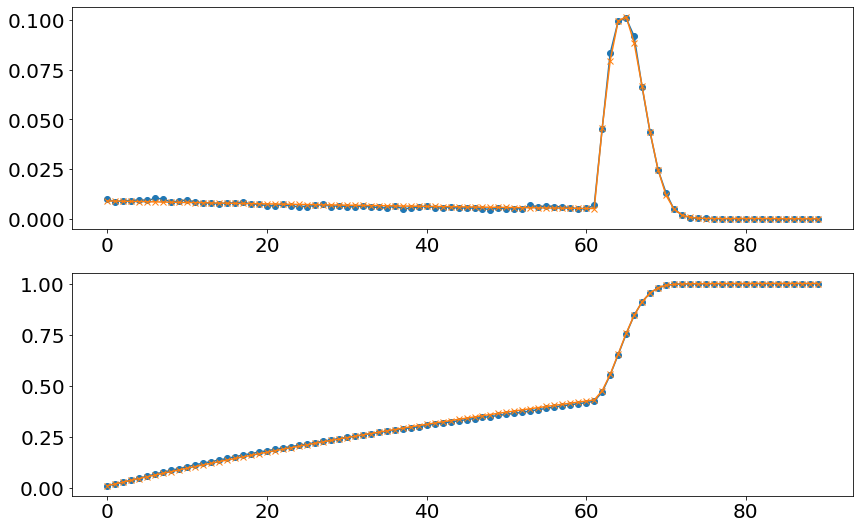

In [356]:
plt.subplot(211)
plt.plot(pm, marker='o')
plt.plot([w_5s(w) for w in range(1,91)], marker='x')

plt.subplot(212)
plt.plot(np.cumsum(pm), marker='o')
plt.plot(np.cumsum([w_5s(w) for w in range(1,91)]), marker='x')
plt.savefig('w5_pc1.png')

In [266]:
.009 + (1-.009)/(76-62)

0.07978571428571428

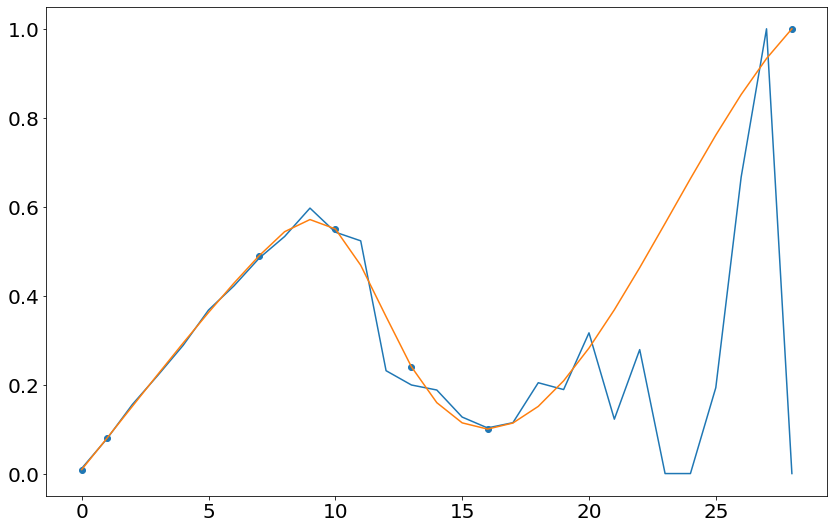

In [267]:
x = np.arange(29)

plt.plot(f)

pts = [[0, .009], [1, .07978], [7,.49], [10, .55], [13, .24], [16, .1], [28, 1]]
pts = np.array(pts)
lint = interp1d(*pts.T, kind='cubic')

plt.scatter(*pts.T)
plt.plot(x, lint(x))
# x2 = x - 1
# plt.plot(-x2*x2*x2/20000)

In [353]:
np.mean(margins[:61]), np.std(margins[:61])

(0.008759325720417481, 0.0010232370234763328)

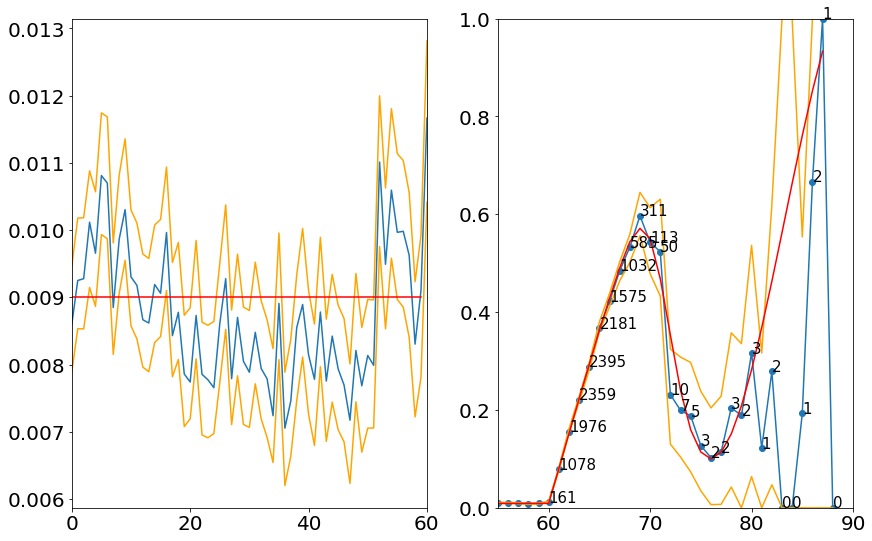

In [350]:
ml = np.array([max((pm[n] - stdevs[n]) / (1-sum(pm[:n])),0) for n in range(1, 90)])
mr = np.array([min((pm[n] + stdevs[n]) / (1-sum(pm[:n])),1) for n in range(1, 90)])
mr[pm[1::]==0] = 1

plt.subplot(121)
plt.plot(margins[:61])
plt.plot(mr[:61], color='orange')
plt.plot(ml[:61], color='orange')

plt.plot([phw(w) for w in range(2, 62)], color='red')
plt.xlim(0, 60)

plt.subplot(122)
plt.plot(margins, marker='o')

plt.plot(mr, color='orange')
plt.plot(ml, color='orange')

plt.plot([phw(w) for w in range(2, 90)], color='red')

for n in range(60, 89):
    an = paimonmoe[n+1] + paaaaaaaa[n+1]
    plt.annotate(f'{an}', (n, margins[n]), size=15)

# plt.plot([76,76],[0,1])
# plt.xlim(0, 60)
# plt.ylim(0, .012)
plt.xlim(55,90)
plt.ylim(0, 1)
# plt.plot([w_5s(w) for w in range(90)])

plt.savefig('paimonmoe_w5_margin.png')

In [281]:
e_5s_multi = distr.MultiDistr(e_5s, 90)

In [289]:
e_5s_multi.std

24.340531096484224

In [302]:
muu, stdd = e_5s_multi.mean*20, e_5s_multi.std*np.sqrt(20)

In [303]:
gus = [np.exp(-0.5*(muu - w)**2 / stdd/stdd) / np.sqrt(2*np.pi) / stdd for w in range(90*20+1)]

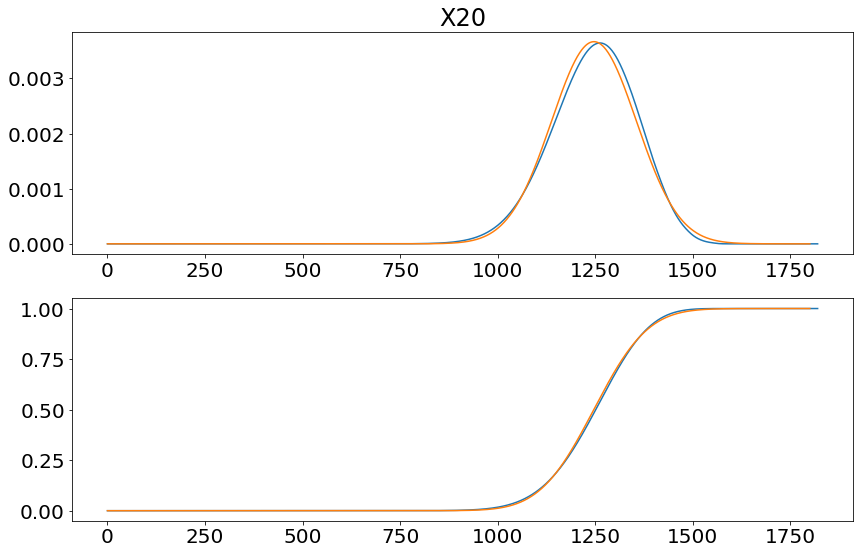

In [313]:
plt.subplot(211)
plt.plot(e_5s_multi.get_distr(20, force_exact=True))
plt.plot(gus)
plt.title('X20')

plt.subplot(212)
plt.plot(np.cumsum(e_5s_multi.get_distr(20, force_exact=True)))
plt.plot(np.cumsum(gus))

plt.savefig('pdfcdf20_cmp.png')

0.018840313137865605

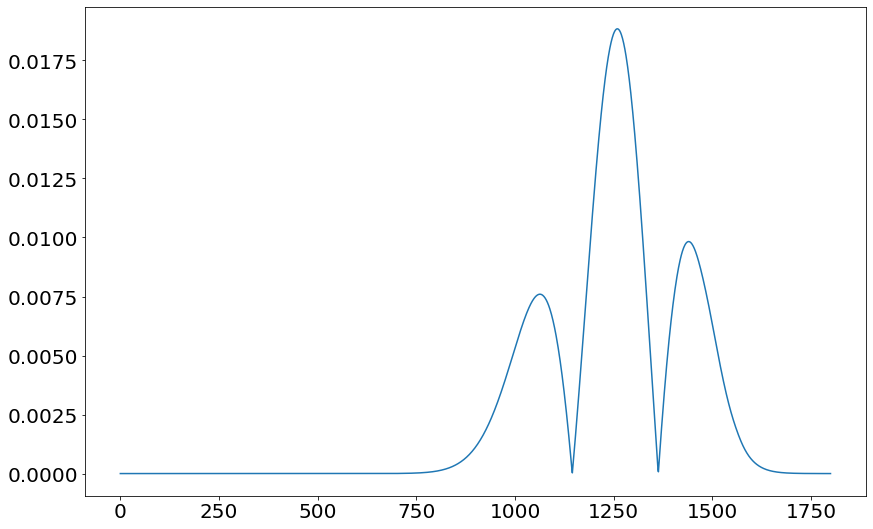

In [315]:
rrr = np.abs(np.cumsum(e_5s_multi.get_distr(20, force_exact=True))[:1800] - np.cumsum(gus)[:1800])
plt.plot(rrr)
np.amax(rrr)
# plt.savefig('20sub.png')

In [197]:
phw(74)

0.06447058823529411

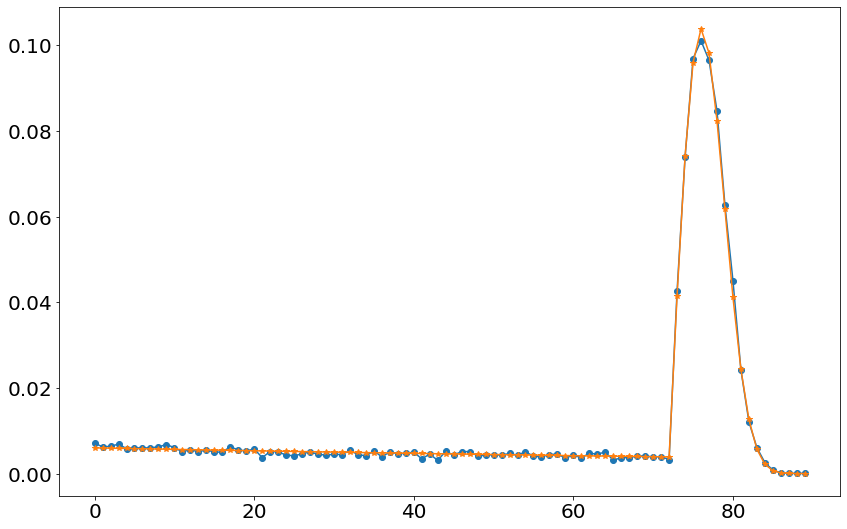

In [210]:
plt.plot(pm, marker='o')
plt.plot([px(w) for w in range(1, 91)], marker='*')
plt.savefig('paimon_cmp.png')

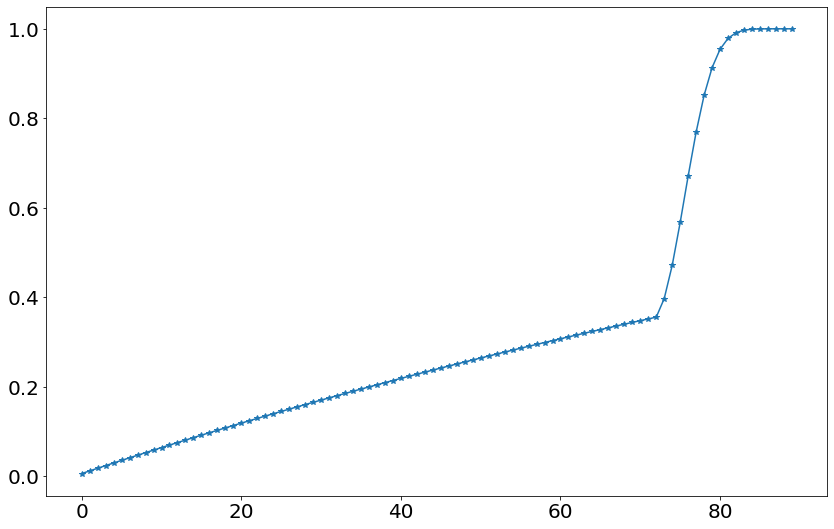

In [218]:
plt.plot(np.cumsum([px(w) for w in range(1, 91)]), marker='*')
plt.savefig('e5_cdf1.png')

In [214]:
np.sqrt(np.sum((pm - [px(w) for w in range(1, 91)])**2))

0.007721980034151069

In [215]:
np.sum(np.abs(pm - [px(w) for w in range(1, 91)]))

0.04914159710584643

In [149]:
stdevs = np.sqrt(pm * (1-pm) / sum(paimonmoe))
margins = [pm[n] / (1-sum(pm[:n])) for n in range(2, 90)]

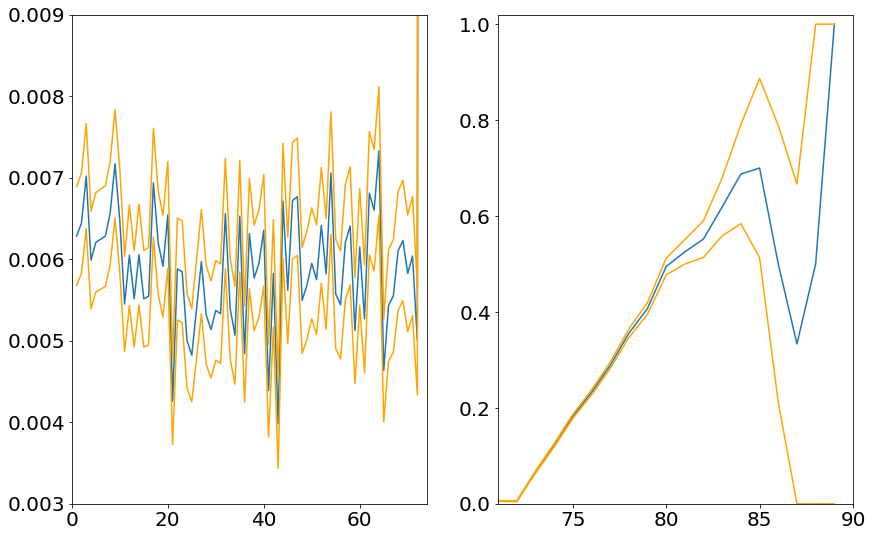

In [180]:
plt.subplot(221)
plt.plot(np.arange(90)+1, pm)

plt.subplot(222)
plt.plot(np.arange(90)+1, pm)
plt.xlim(73, 90)

plt.subplot(121)
margins = [pm[n] / (1-sum(pm[:n])) for n in range(1, 90)]
marginserrl = [max((pm[n] - stdevs[n]) / (1-sum(pm[:n])),0) for n in range(1, 90)]
marginserru = [min((pm[n] + stdevs[n]) / (1-sum(pm[:n])),1) for n in range(1, 90)]
plt.plot(np.arange(89)+1,margins)
plt.plot(np.arange(89)+1,marginserrl, color='orange')
plt.plot(np.arange(89)+1,marginserru, color='orange')
plt.xlim(0, 74)
plt.ylim(.003, .009)

plt.subplot(122)
plt.plot(np.arange(89)+1,margins)
plt.plot(np.arange(89)+1,marginserrl, color='orange')
plt.plot(np.arange(89)+1,marginserru, color='orange')
plt.xlim(71,90)
plt.ylim(0,1.02)

plt.savefig('paimonmoe.png')

In [106]:
sum(e_5s_multi.get_distr(1)[:73]), 1-(1-.006)**72, sum(pm[:73])

(0.3516348300231231, 0.35163483002312357, 0.3506675217163178)

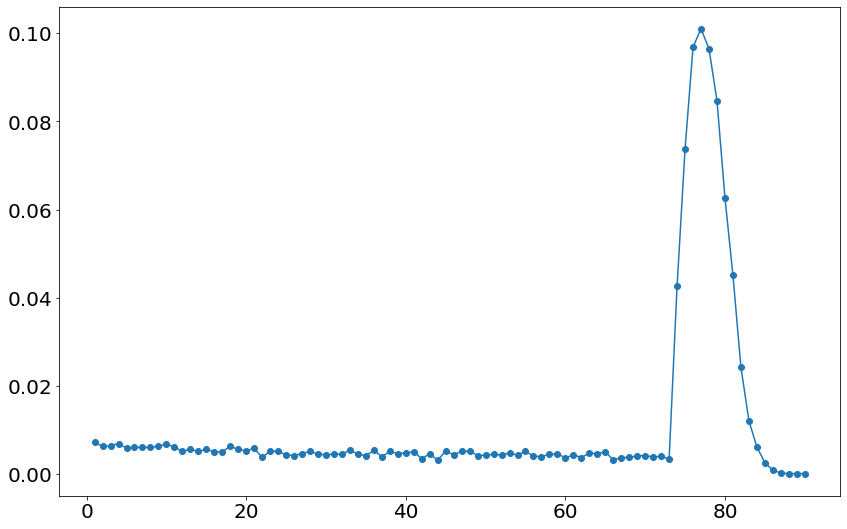

In [146]:
plt.plot(np.arange(90)+1, pm, marker='o')
# plt.savefig

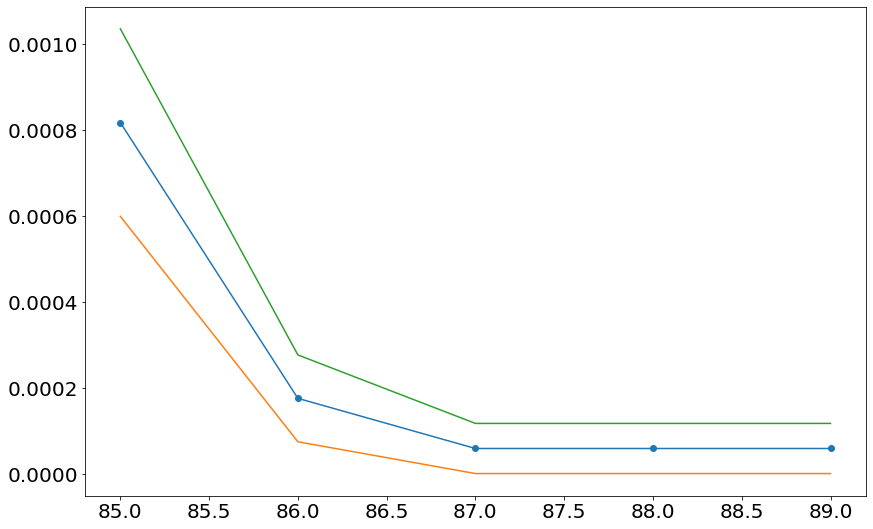

In [143]:
pm = np.array(paimonmoe) / sum(paimonmoe)

stdevs = np.sqrt(pm * (1-pm) / sum(paimonmoe))

plt.plot(np.arange(85, 90), pm[85:], marker='o')
plt.plot(np.arange(85, 90), (pm - stdevs)[85:])
plt.plot(np.arange(85, 90), (pm + stdevs)[85:])
# plt.plot(range(1, 74), e_5s_multi.get_distr(1)[1:74])


In [65]:
errs = np.abs(pm[:73] - e_5s_multi.get_distr(1)[1:74])

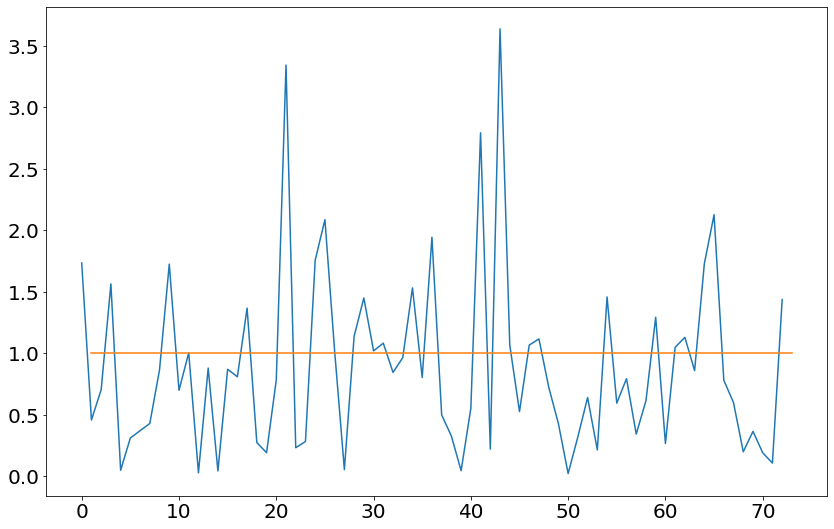

In [70]:
plt.plot(errs / stdevs[:73])
plt.plot([1, 73], [1,1])

In [80]:
1 - np.count_nonzero((errs / stdevs[:73]) > 2) / 73

0.9315068493150684

In [4]:
event_5star = distr.wish_distr(.006, 0.32383924389327824, pity=75, hard=90)
event_4star = distr.wish_distr(.051, 1, pity=9, hard=10)
weap_5star = distr.wish_distr(.007, 0.375056953108059194274565981567885, pity=65, hard=80)
weap_4star = distr.wish_distr(.06, 1, pity=9, hard=10)

In [16]:
e_5s_multi = distr.MultiDistr(event_5star, 90)
e_4s_multi = distr.MultiDistr(event_4star, 10)
w_5s_multi = distr.MultiDistr(weap_5star, 80)
w_4s_multi = distr.MultiDistr(weap_4star, 10)

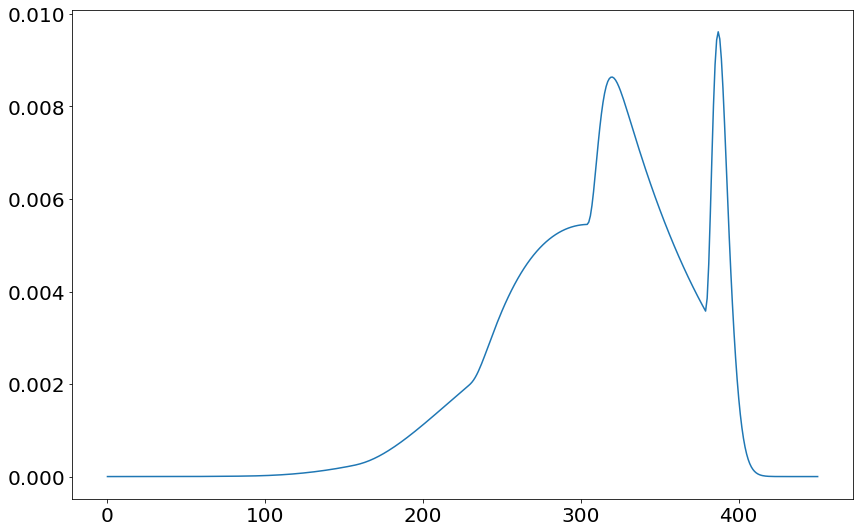

In [18]:
plt.plot([e_5s_multi.p_iter(w, 5) for w in range(90*5+1)])

In [19]:
def e_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 2 / (np.sqrt(13))
    a3= -.5 + 2 / (np.sqrt(13))
    l2 = (1+np.sqrt(13))/6
    l3 = (1-np.sqrt(13))/6
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def e_4s_hit(w):
    return sum([e_pan(n) * e_4s_multi.p_iter(w, n) for n in range(w+1)])

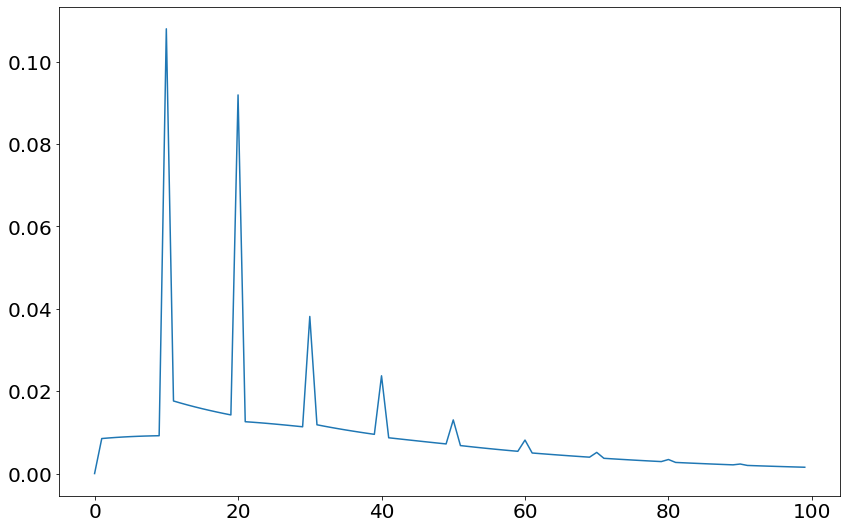

In [20]:
plt.plot([e_4s_hit(w) for w in range(100)])

In [21]:
def w_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 11/(4*np.sqrt(29))
    a3 = -.5 + 11/(4*np.sqrt(29))
    l2 = (3+np.sqrt(29)) / 10
    l3 = (3-np.sqrt(29)) / 10
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def w_4s_hit(w):
    return sum([w_pan(n) * w_4s_multi.p_iter(w, n) for n in range(w+1)])

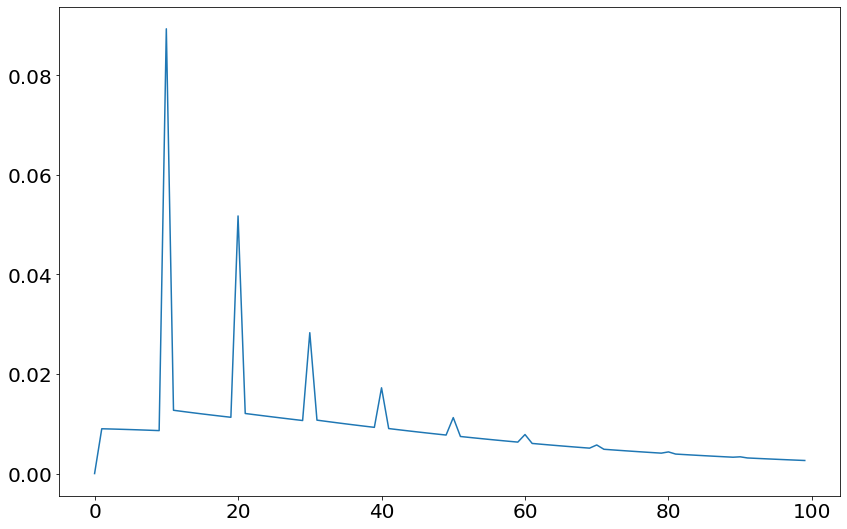

In [22]:
plt.plot([w_4s_hit(w) for w in range(100)])

In [23]:
def w5_pan(n: int) -> float:
    if n == 0: return 0

    a2 = -.5 - 7/(2*np.sqrt(41))
    a3 = -.5 + 7/(2*np.sqrt(41))
    l2 = (3+np.sqrt(41)) / 16
    l3 = (3-np.sqrt(41)) / 16
    return a2 * (l2-1) * l2**(n-1) + a3 * (l3-1) * l3**(n-1)

@cache
def w_5s_hit(w):
    return sum([w5_pan(n) * w_5s_multi.p_iter(w, n) for n in range(w+1)])

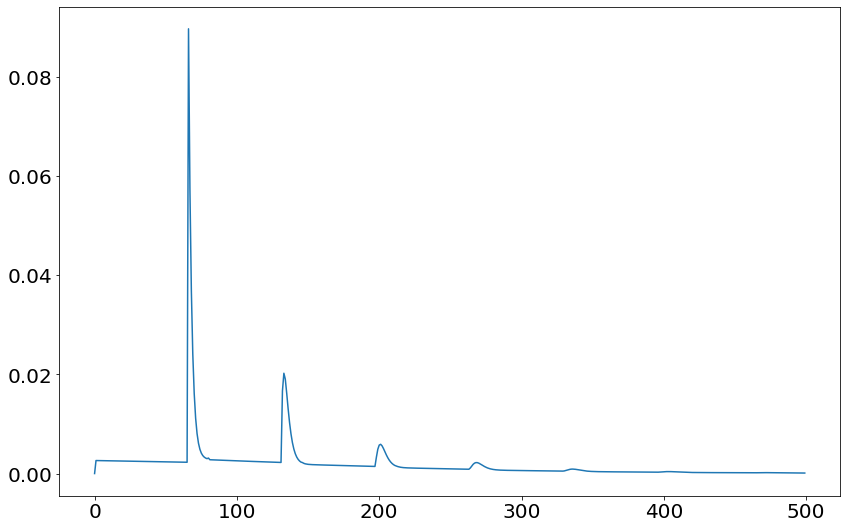

In [40]:
plt.plot([w_5s_hit(w) for w in range(500)])

In [28]:
np.sum([w_5s_hit(w) for w in range(1000)])

0.999898012304135

In [30]:
np.sum(np.arange(1000) * [w_5s_hit(w) for w in range(1000)])

135.02248370913716

In [32]:
cdf = np.cumsum([w_5s_hit(w) for w in range(800)])

In [35]:
np.argmin(np.abs(cdf - .8))

201

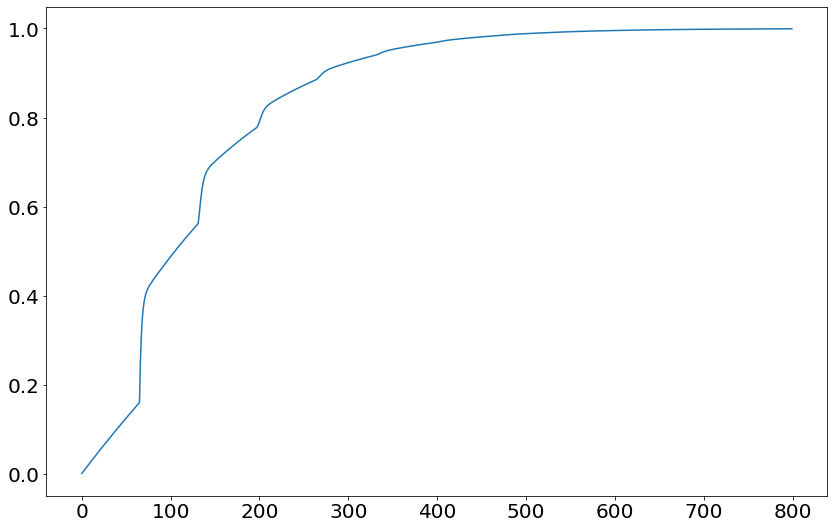

In [29]:
plt.plot(np.cumsum([w_5s_hit(w) for w in range(800)]))
# plt.plot([w_4s_hit(w) for w in range(100)])